In [73]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/데이터스쿨 공부코드/project/Final_project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/데이터스쿨 공부코드/project/Final_project


In [74]:
# 코랩 한글폰트 설치: 1회 설치 후 런타임 재실행 -> 재실행시에는 건너뛰기
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import platform as pf
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import datetime
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
# 마이너스 기호 문제 해결하기
# mpl.rcParams['axes.unicode_minus'] = False

In [76]:
customer_buyinginfo_df = pd.read_csv('./customer_buyinginfo_df.csv', index_col=0)
customer_buyinginfo_df.head()

고객ID        가입날짜      최초거래날짜      최근거래날짜  구매횟수  구매제품수      구매원가  \
0  USER_0000  2017-04-18  2019-09-15  2019-09-15     1      3     35.69   
1  USER_0001  2018-03-13  2019-03-24  2019-11-02    31    342  15902.78   
2  USER_0002  2016-09-13  2019-06-22  2019-10-19     8    209   1645.73   
3  USER_0003  2017-11-28  2019-12-14  2019-12-14    11     21   1508.36   
4  USER_0004  2017-04-18  2019-09-15  2019-09-15    13     56   1594.23   

        할인가     배송료     총결제금액  평균결제금액  평균할인차액  평균할인비율  구매제품평균금액  
0     24.98   75.00     99.98   99.98  -10.71    0.11      8.33  
1  15021.67  286.46  15308.13  493.81  -28.42    0.06     43.92  
2   1492.42   81.07   1573.49  196.69  -19.16    0.10      7.14  
3   1339.57   82.39   1421.96  129.27  -15.34    0.12     63.79  
4   1369.93  154.49   1524.42  117.26  -17.25    0.15     24.46

In [77]:
# 날짜 컬럼 3개 수정하기: 2019년 말일 기준으로 일 기준으로 환산하기 (+1일)
today = datetime.date(2019, 12, 31)
customer_buyinginfo_df['최근거래날짜'] = [(today - datetime.date.fromisoformat(i)).days + 1 for i in customer_buyinginfo_df['최근거래날짜']]    # +1일
customer_buyinginfo_df['가입날짜'] = [(today - datetime.date.fromisoformat(i)).days + 1 for i in customer_buyinginfo_df['가입날짜']]    # +1일
customer_buyinginfo_df['최초거래날짜'] = [(today - datetime.date.fromisoformat(i)).days + 1 for i in customer_buyinginfo_df['최초거래날짜']]    # +1일

customer_buyinginfo_df.head(2)

고객ID  가입날짜  최초거래날짜  최근거래날짜  구매횟수  구매제품수      구매원가       할인가     배송료  \
0  USER_0000   988     108     108     1      3     35.69     24.98   75.00   
1  USER_0001   659     283      60    31    342  15902.78  15021.67  286.46   

      총결제금액  평균결제금액  평균할인차액  평균할인비율  구매제품평균금액  
0     99.98   99.98  -10.71    0.11      8.33  
1  15308.13  493.81  -28.42    0.06     43.92

---
# 모든 속성으로 KMeans
- 참고: https://velog.io/@mios_leo/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD-%EA%B0%80%EC%9D%B4%EB%93%9C-8.-Clustering1-K-Mean-Cluster-Evaluation

In [78]:
kmeans_df = customer_buyinginfo_df.copy()
kmeans_df.tail()

고객ID  가입날짜  최초거래날짜  최근거래날짜  구매횟수  구매제품수     구매원가      할인가     배송료  \
1463  USER_1463   183     271     271     3     46   595.58   582.38   94.35   
1464  USER_1464  1352     193      88    19    141  2640.23  2384.13  222.05   
1465  USER_1465   764     271     195     2     10   119.58   115.40   12.50   
1466  USER_1466  1499      70      70     1      2   327.80   327.80    6.00   
1467  USER_1467  1093     156      83    53    155  6946.00  6639.16  337.87   

        총결제금액  평균결제금액  평균할인차액  평균할인비율  구매제품평균금액  
1463   676.73  225.58   -4.40    0.02     12.66  
1464  2606.18  137.17  -13.48    0.10     16.91  
1465   127.90   63.95   -2.09    0.03     11.54  
1466   333.80  333.80    0.00    0.00    163.90  
1467  6977.03  131.64   -5.79    0.04     42.83

K-means++ 방식
1. 데이터 포인트 중에서 무작위로 1개를 선택하여 중심점으로 지정
2. 나머지 데이터 포인트들에 대해 첫 번째 중심점까지의 거리 계산
3. 지정된 중심점으로부터 가장 멀리 있는 데이터 포인트를 다음 중심점으로 지정
4. 중심점이 K개가 될 때까지 2, 3번 반복 |
| max_iter | 최대 반복 횟수. 이 횟수 이전에 모든 데이터의 중심점 이동이 없으면 종료 |

In [79]:
# 실루엣 분석 metric 값을 구하기 위한 API 추가
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

kmeans = KMeans(n_clusters=7, init='k-means++', max_iter=300, random_state=13)
kmeans.fit(kmeans_df.drop('고객ID', axis=1))

kmeans_df['cluster'] = kmeans.labels_
kmeans_df.value_counts('cluster')

# kmeans_df의 모든 개별 데이터에 실루엣 계수값을 구함.
score_samples = silhouette_samples(kmeans_df.drop('고객ID', axis=1), kmeans_df['cluster'])
print('-' * 50)
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)
print(np.mean(silhouette_samples(kmeans_df.drop('고객ID', axis=1), kmeans_df['cluster'])))
print(silhouette_score(kmeans_df.drop('고객ID', axis=1), kmeans_df['cluster']))

# irisDF에 실루엣 계수 컬럼 추가
kmeans_df['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함.
average_score = silhouette_score(kmeans_df.drop('고객ID', axis=1), kmeans_df['cluster'])
print('-' * 50)
print('고객 데이터셋 Silhouette Analysis Score:{0:.3f}'.format(average_score))

# 군집별 평균 실루엣 계수
print(kmeans_df.groupby('cluster')['silhouette_coeff'].mean())



--------------------------------------------------
silhouette_samples( ) return 값의 shape (1468,)
0.5730832681457866
0.5730832681457866
--------------------------------------------------
고객 데이터셋 Silhouette Analysis Score:0.573
cluster
0    0.639351
1    0.368975
2    0.576059
3    0.473930
4    0.477229
5    0.924461
6    0.501578
Name: silhouette_coeff, dtype: float64


- 실루엣 계수는 -1~1 사이의 값을 가짐
  - 1로 가까울 수록, 근처의 군집과 더 멀리 떨여지 있다는 것
  - 0에 가까울 수록, 근처의 군집과 가까워진다는 것
  - -값이면 다른 군집에 데이터 포인트가 할당되었다는 것
  - 일반적으로 이 값이 높을수록 군집화가 어느정도 잘 됐다고 판단할 수 있지만, 무조건 그런건 아니다.

- 전체 데이터의 평균 실루엣 계수 값이 높다고 해서, 반드시 최적의 군집 개수로 군집화가 잘 됐다고 볼 수 없음
  - 특정 군집만 실루엣 계수가 엄청 높고 나머지 군집들은 낮아도, 평균 실루엣 계수 자체는 높게 나올 수 있기 때문
- 따라서, 좋은 군집의 조건으로
  - 전체 실루엣 계수의 평균값(silhouette_score())은 0~1 사이의 값을 가지며, 1에 가까울 수록 좋다.
  - 하지만 전체 실루엣 계수의 평균값과 더불어, 개별 군집의 평균값의 편차가 크지 않아야 한다.
  - 즉, 개별 군집의 실루엣 계수 평균값이 전체 실루엣 계수 평균값에서 크게 벗어나지 않는 것이 중요하다.

{4: array([0, 1, 0, ..., 0, 0, 3], dtype=int32),
 5: array([0, 1, 0, ..., 0, 0, 3], dtype=int32),
 6: array([3, 2, 3, ..., 3, 3, 4], dtype=int32),
 7: array([0, 2, 0, ..., 0, 0, 6], dtype=int32),
 8: array([0, 4, 0, ..., 0, 0, 6], dtype=int32),
 9: array([0, 8, 4, ..., 0, 0, 1], dtype=int32),
 10: array([8, 5, 0, ..., 8, 8, 2], dtype=int32)}

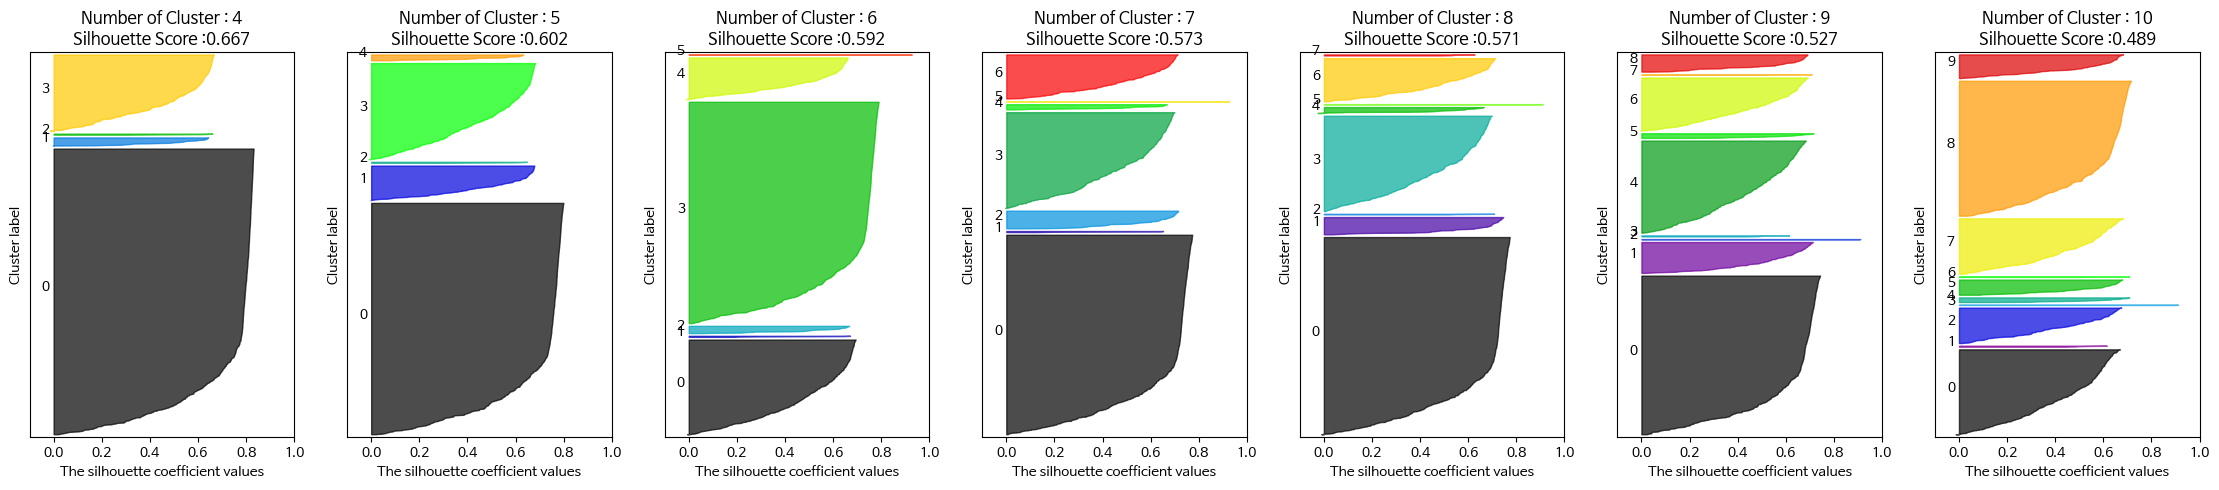

In [80]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 5), nrows=1, ncols=n_cols)

    # cluster label 추출
    labels = {}

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=13)
        cluster_labels = clusterer.fit_predict(X_features)
        labels[n_cluster] = cluster_labels
        centers = clusterer.cluster_centers_

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

    return labels

# cluster 개수를 2개, 3개, 4개, 5개, 6개, 7개 일때의 클러스터별 실루엣 계수 평균값을 시각화
visualize_silhouette([4, 5, 6, 7, 8, 9, 10], kmeans_df.drop('고객ID', axis=1))

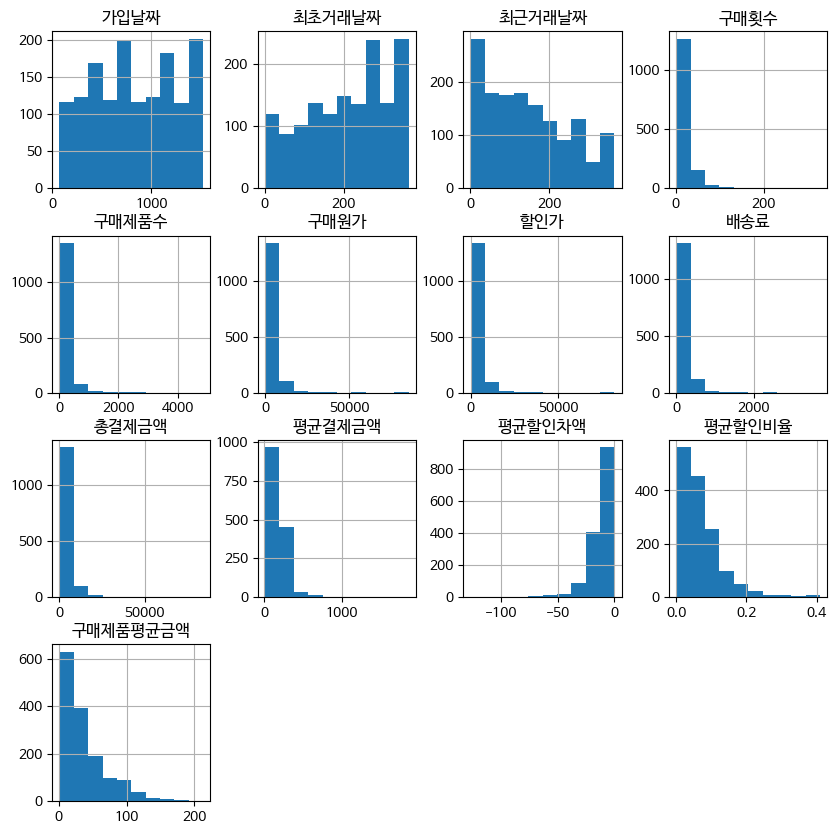

In [81]:
customer_buyinginfo_df.hist(figsize = (10, 10));

---
# Features 수 줄이기 -> 8 Features

In [82]:
new_df = customer_buyinginfo_df.copy()
new_features_df = new_df.drop(['가입날짜', '고객ID', '평균결제금액', '평균할인차액', '평균할인비율', '구매제품평균금액'], axis=1)
new_features_df.head()

최초거래날짜  최근거래날짜  구매횟수  구매제품수      구매원가       할인가     배송료     총결제금액
0     108     108     1      3     35.69     24.98   75.00     99.98
1     283      60    31    342  15902.78  15021.67  286.46  15308.13
2     193      74     8    209   1645.73   1492.42   81.07   1573.49
3      18      18    11     21   1508.36   1339.57   82.39   1421.96
4     108     108    13     56   1594.23   1369.93  154.49   1524.42

{4: array([0, 1, 0, ..., 0, 0, 2], dtype=int32),
 5: array([0, 1, 0, ..., 0, 0, 3], dtype=int32),
 6: array([2, 3, 2, ..., 2, 2, 0], dtype=int32),
 7: array([0, 2, 0, ..., 0, 0, 4], dtype=int32),
 8: array([3, 2, 3, ..., 3, 3, 7], dtype=int32),
 9: array([0, 1, 5, ..., 0, 0, 8], dtype=int32),
 10: array([8, 1, 0, ..., 8, 8, 9], dtype=int32)}

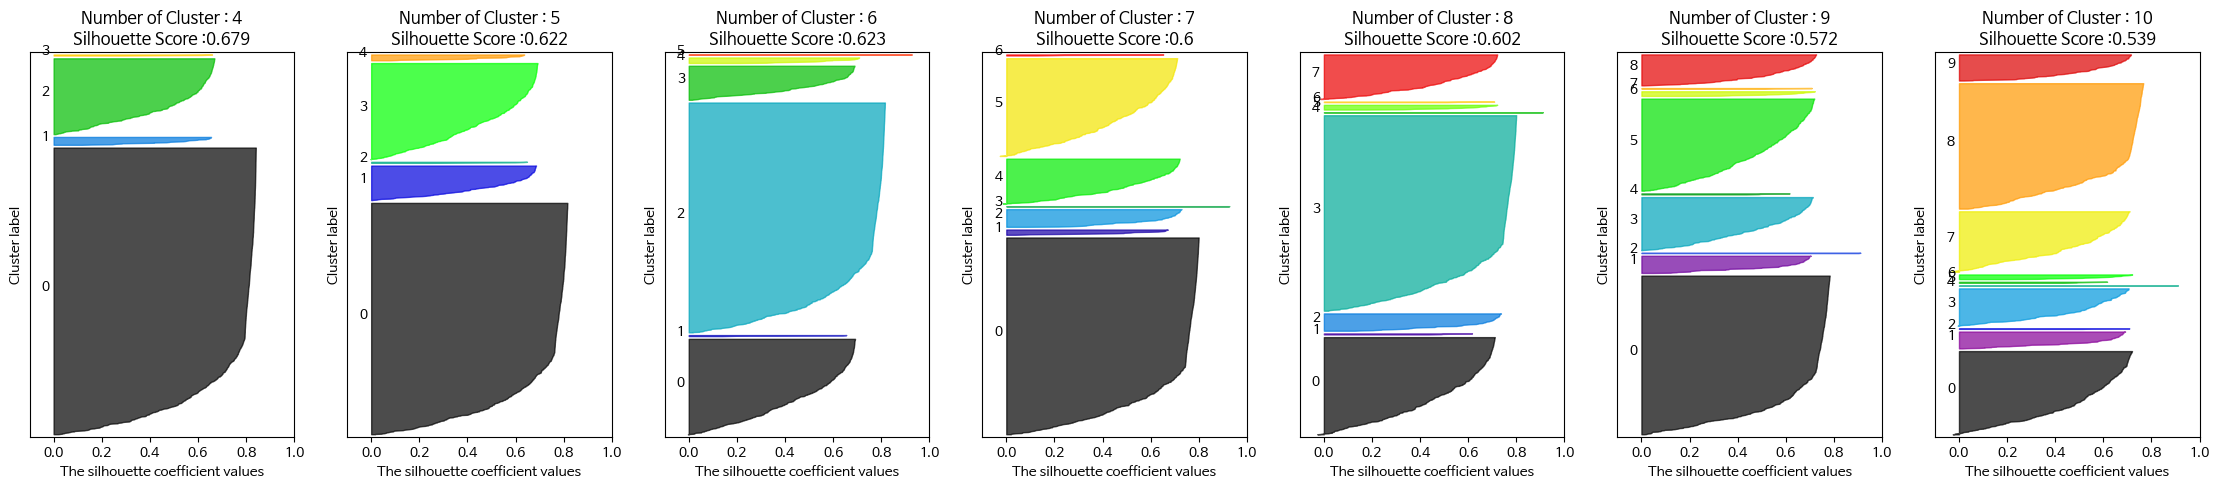

In [83]:
# cluster 개수를 2개, 3개, 4개, 5개, 6개, 7개 일때의 클러스터별 실루엣 계수 평균값을 시각화
visualize_silhouette([4, 5, 6, 7, 8, 9, 10], new_features_df)

---
# 8 Features 데이터 분포 변환하기
### Robust Scaler 적용하기
- 평균과 분산 대신에 중간값과 사분위값 사용
중앙값(median)과 IQR(interquartile range) 사용. 아웃라이어의 영향을 최소화
- RobustScaler는 특성들이 같은 스케일을 갖게 되지만 평균대신 중앙값을 사용 ==> 극단값에 영향을 받지 않음
- https://wikidocs.net/89704
- https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=demian7607&logNo=222009975984

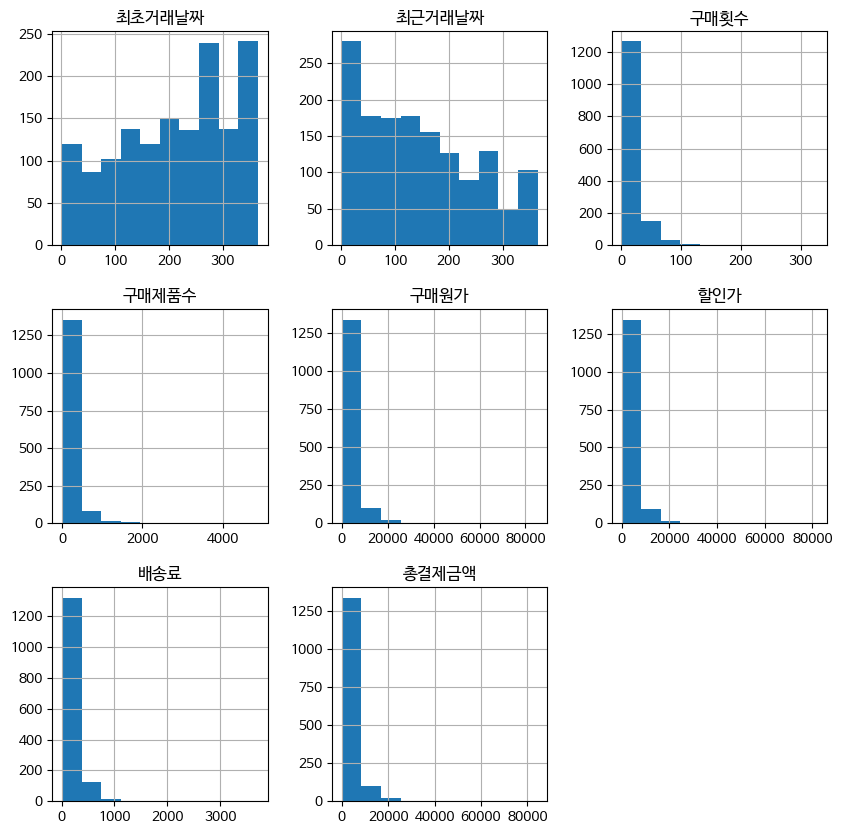

In [84]:
new_features_df.hist(figsize=(10, 10));

In [85]:
rs_features_df = new_features_df.copy()

In [86]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()

rs_features_df = pd.DataFrame(rs.fit_transform(rs_features_df), columns = rs_features_df.columns)
rs_features_df.head()


최초거래날짜    최근거래날짜      구매횟수     구매제품수      구매원가       할인가       배송료  \
0 -0.691729 -0.145455 -0.555556 -0.364780 -0.520975 -0.520220 -0.111722   
1  0.360902 -0.436364  1.111111  1.767296  3.841310  3.883231  1.180663   
2 -0.180451 -0.351515 -0.166667  0.930818 -0.078332 -0.089338 -0.074624   
3 -1.233083 -0.690909  0.000000 -0.251572 -0.116099 -0.134219 -0.066557   
4 -0.691729 -0.145455  0.111111 -0.031447 -0.092491 -0.125304  0.374099   

      총결제금액  
0 -0.505632  
1  3.768004  
2 -0.091561  
3 -0.134143  
4 -0.105350

In [87]:
rs_features_df.describe()

최초거래날짜       최근거래날짜         구매횟수        구매제품수          구매원가  \
count  1468.000000  1468.000000  1468.000000  1468.000000  1.468000e+03   
mean     -0.080293     0.080559     0.396723     0.636150  4.403231e-01   
std       0.629640     0.617800     1.387579     1.964617  1.550980e+00   
min      -1.335338    -0.793939    -0.555556    -0.377358 -5.304845e-01   
25%      -0.565414    -0.460606    -0.333333    -0.264151 -3.301036e-01   
50%       0.000000     0.000000     0.000000     0.000000 -3.125213e-17   
75%       0.434586     0.539394     0.666667     0.735849  6.698964e-01   
max       0.854135     1.412121    17.611111    30.238994  2.292354e+01   

                할인가          배송료        총결제금액  
count  1.468000e+03  1468.000000  1468.000000  
mean   4.406858e-01     0.424875     0.438651  
std    1.556256e+00     1.453519     1.551158  
min   -5.272637e-01    -0.533431    -0.531763  
25%   -3.298553e-01    -0.334922    -0.332876  
50%   -3.339343e-17     0.000000     0.000000  
75%    6.701447e-01     0.665078     0.667124  
max    2.357167e+01    22.136903    23.185120

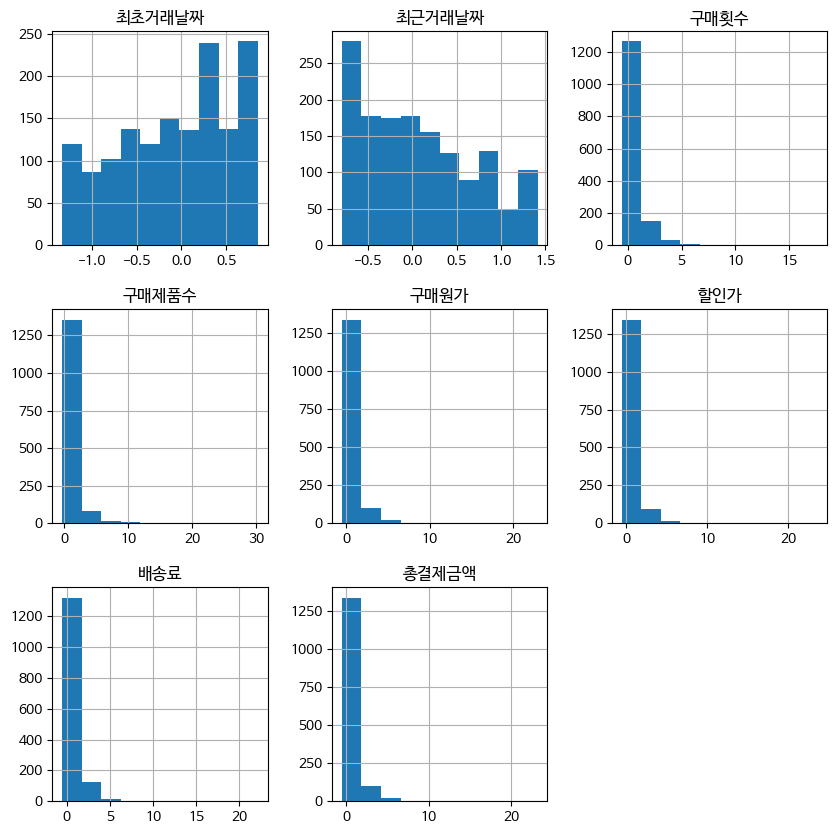

In [88]:
rs_features_df.hist(figsize=(10, 10));

{4: array([0, 3, 0, ..., 0, 0, 3], dtype=int32),
 5: array([0, 3, 0, ..., 0, 0, 1], dtype=int32),
 6: array([5, 3, 5, ..., 0, 5, 2], dtype=int32),
 7: array([0, 3, 4, ..., 0, 0, 6], dtype=int32),
 8: array([0, 2, 0, ..., 7, 0, 4], dtype=int32),
 9: array([8, 0, 8, ..., 1, 8, 5], dtype=int32),
 10: array([6, 5, 6, ..., 2, 6, 5], dtype=int32)}

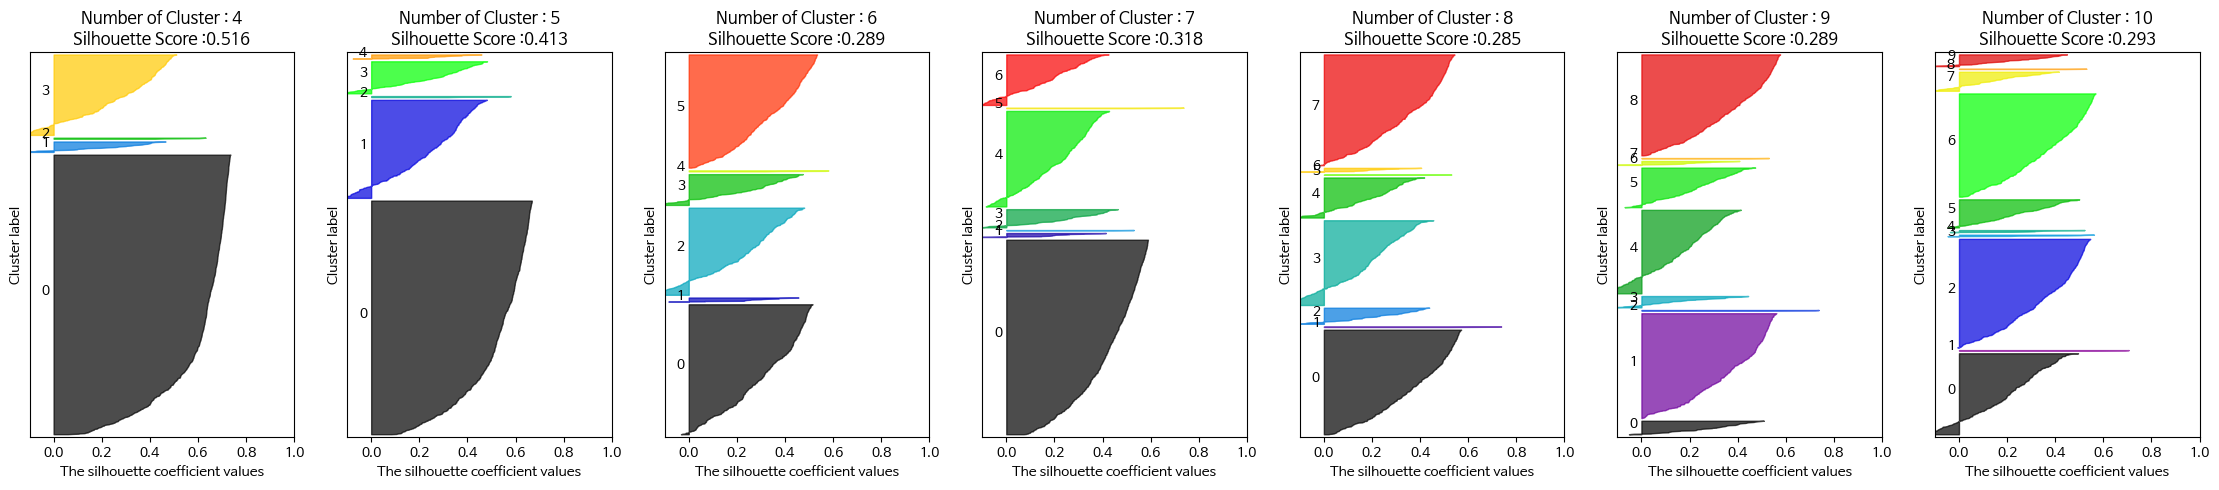

In [89]:
# cluster 개수를 2개, 3개, 4개, 5개, 6개, 7개 일때의 클러스터별 실루엣 계수 평균값을 시각화
visualize_silhouette([4, 5, 6, 7, 8, 9, 10], rs_features_df)

---
## MinMax Scaler

In [90]:
mm_features_df = new_features_df.copy()

In [91]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

mm_features_df = pd.DataFrame(mm.fit_transform(mm_features_df), columns = mm_features_df.columns)
mm_features_df.head()

최초거래날짜    최근거래날짜      구매횟수     구매제품수      구매원가       할인가       배송료  \
0  0.293956  0.293956  0.000000  0.000411  0.000405  0.000292  0.018602   
1  0.774725  0.162088  0.091743  0.070049  0.186398  0.183016  0.075610   
2  0.527473  0.200549  0.021407  0.042728  0.019278  0.018172  0.020238   
3  0.046703  0.046703  0.030581  0.004108  0.017668  0.016310  0.020594   
4  0.293956  0.293956  0.036697  0.011298  0.018675  0.016680  0.040032   

      총결제금액  
0  0.001102  
1  0.181296  
2  0.018561  
3  0.016765  
4  0.017979

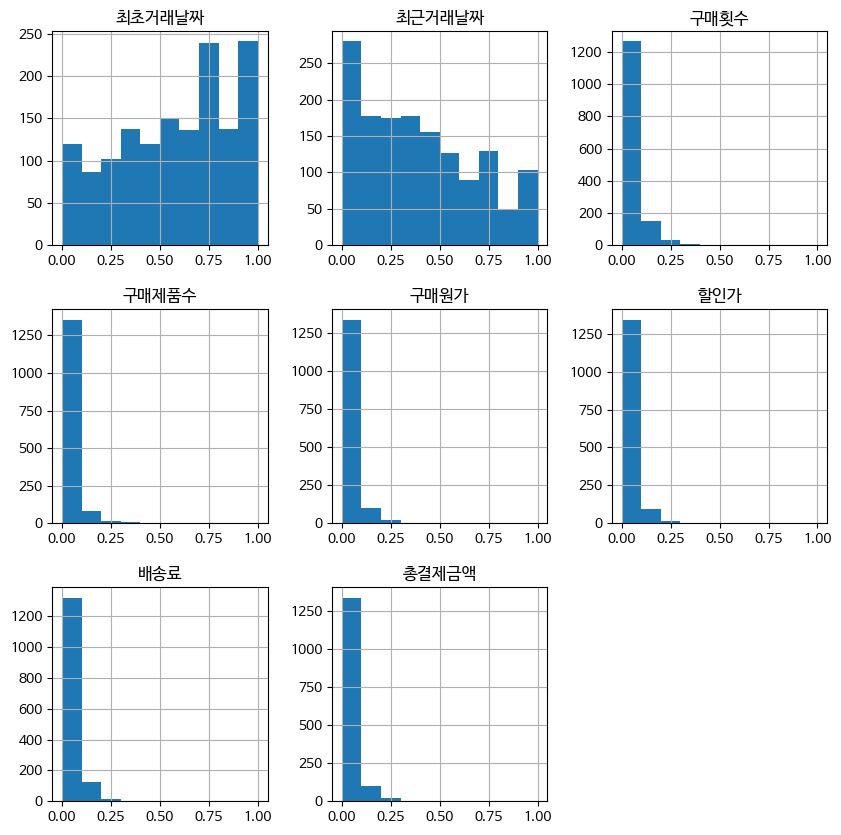

In [92]:
mm_features_df.hist(figsize=(10, 10));

{4: array([0, 1, 2, ..., 2, 0, 0], dtype=int32),
 5: array([0, 2, 3, ..., 3, 0, 0], dtype=int32),
 6: array([1, 0, 1, ..., 4, 3, 1], dtype=int32),
 7: array([6, 1, 6, ..., 2, 0, 6], dtype=int32),
 8: array([1, 2, 5, ..., 7, 3, 5], dtype=int32),
 9: array([5, 3, 6, ..., 7, 0, 6], dtype=int32),
 10: array([0, 8, 2, ..., 6, 4, 2], dtype=int32)}

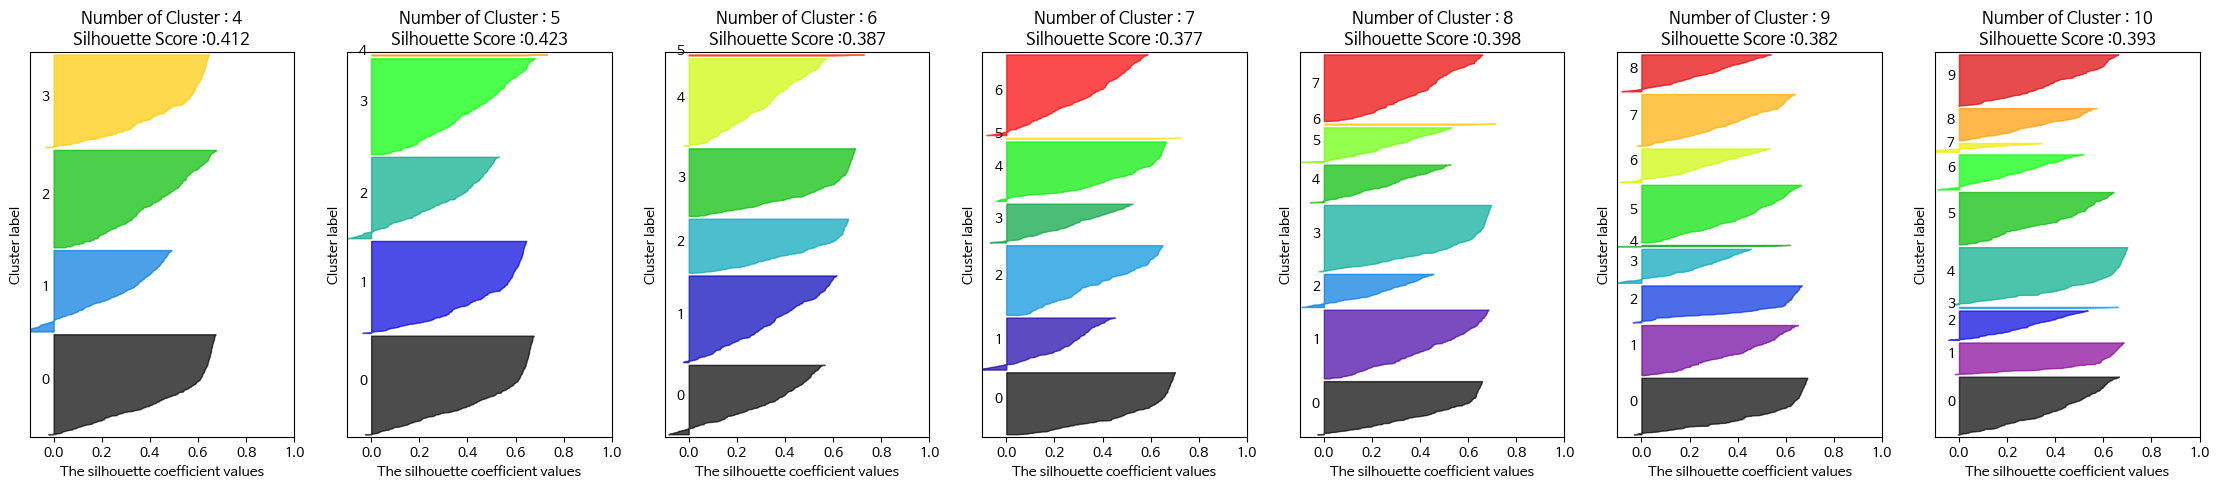

In [93]:
visualize_silhouette([4, 5, 6, 7, 8, 9, 10], mm_features_df)

---
## Standard Scaler

In [94]:
ss_features_df = new_features_df.copy()

In [95]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss_features_df = pd.DataFrame(ss.fit_transform(ss_features_df), columns = ss_features_df.columns)
ss_features_df.head()

최초거래날짜    최근거래날짜      구매횟수     구매제품수      구매원가       할인가       배송료  \
0 -0.971419 -0.365961 -0.686522 -0.509652 -0.620011 -0.617657 -0.369297   
1  0.700949 -0.837001  0.515021  0.575955  2.193545  2.212822  0.520148   
2 -0.159126 -0.699614 -0.406162  0.150039 -0.334519 -0.340692 -0.343765   
3 -1.831494 -1.249160 -0.286007 -0.452009 -0.358877 -0.369541 -0.338213   
4 -0.971419 -0.365961 -0.205905 -0.339926 -0.343651 -0.363811 -0.034946   

      총결제금액  
0 -0.608968  
1  2.147098  
2 -0.341934  
3 -0.369394  
4 -0.350826

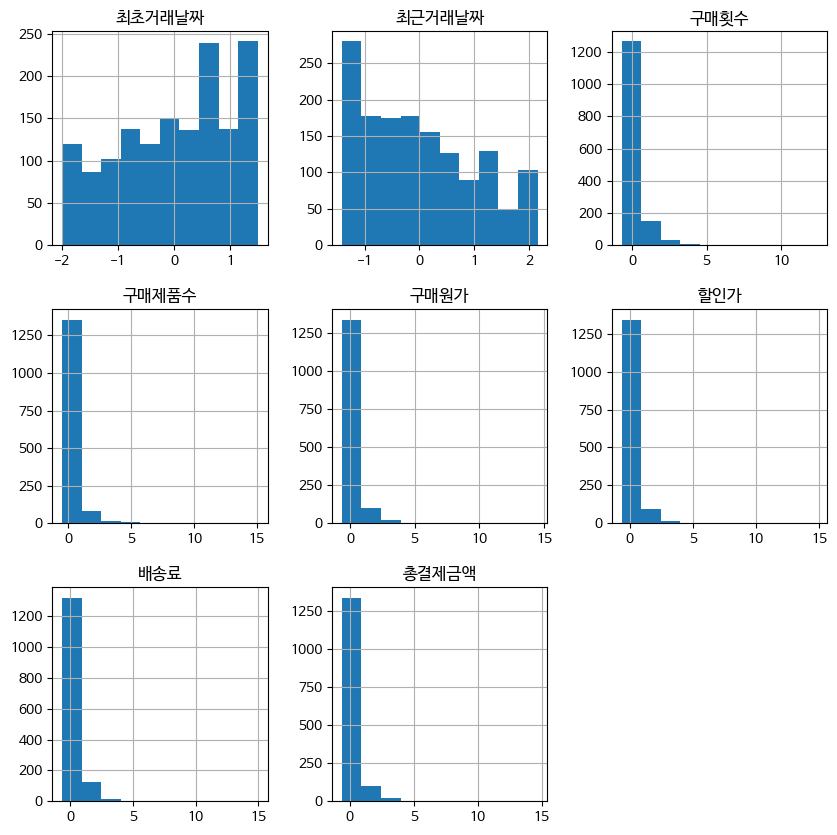

In [96]:
ss_features_df.hist(figsize=(10, 10));

{4: array([3, 2, 3, ..., 0, 3, 2], dtype=int32),
 5: array([0, 4, 0, ..., 2, 0, 4], dtype=int32),
 6: array([5, 3, 5, ..., 2, 5, 3], dtype=int32),
 7: array([3, 4, 3, ..., 3, 0, 4], dtype=int32),
 8: array([5, 4, 5, ..., 5, 0, 4], dtype=int32),
 9: array([4, 3, 6, ..., 6, 4, 0], dtype=int32),
 10: array([7, 8, 0, ..., 0, 7, 3], dtype=int32)}

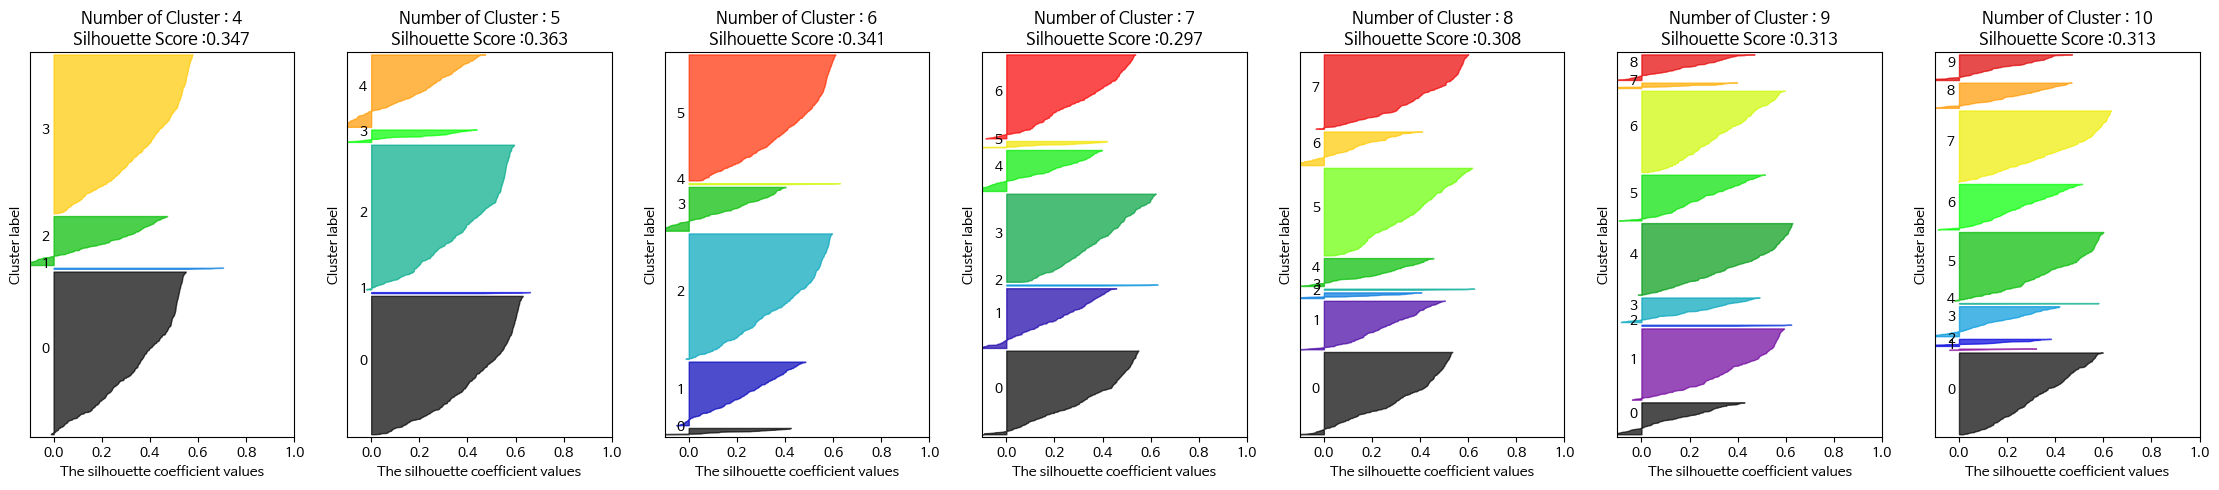

In [97]:
visualize_silhouette([4, 5, 6, 7, 8, 9, 10], ss_features_df)

---
## Log Scale

In [98]:
log_features_df = new_features_df.copy()

In [99]:
log_features_df = np.log(log_features_df)
log_features_df.head()

최초거래날짜    최근거래날짜      구매횟수     구매제품수      구매원가       할인가       배송료  \
0  4.682131  4.682131  0.000000  1.098612  3.574871  3.218076  4.317488   
1  5.645447  4.094345  3.433987  5.834811  9.674249  9.617249  5.657599   
2  5.262690  4.304065  2.079442  5.342334  7.405939  7.308154  4.395313   
3  2.890372  2.890372  2.397895  3.044522  7.318778  7.200104  4.411464   
4  4.682131  4.682131  2.564949  4.025352  7.374146  7.222515  5.040129   

      총결제금액  
0  4.604970  
1  9.636139  
2  7.361051  
3  7.259791  
4  7.329369

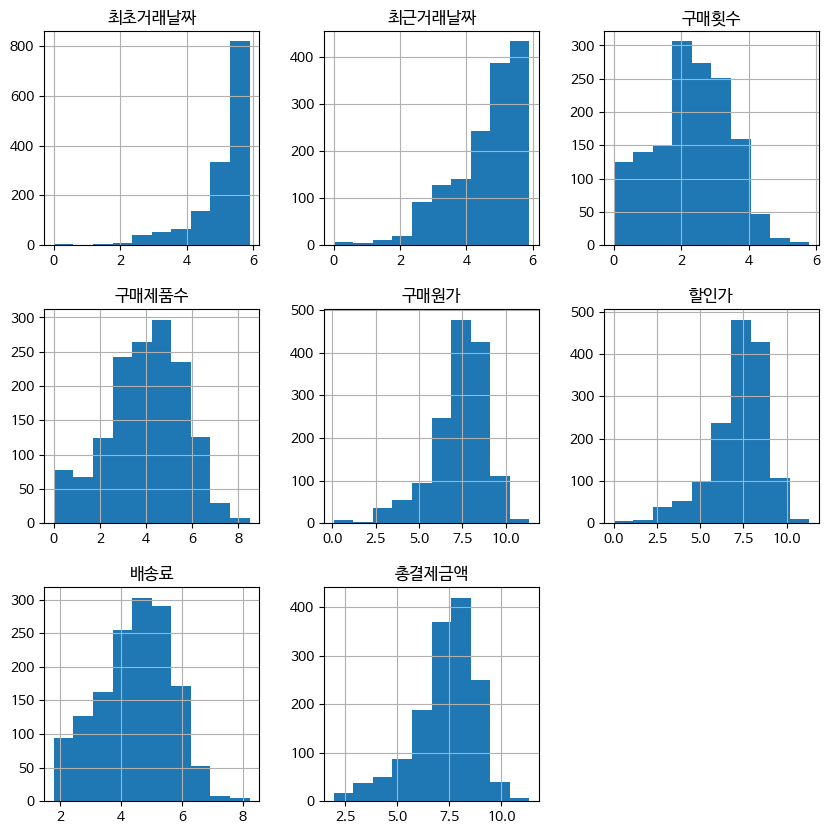

In [100]:
log_features_df.hist(figsize=(10, 10));

{4: array([1, 3, 0, ..., 1, 1, 3], dtype=int32),
 5: array([0, 1, 4, ..., 0, 0, 1], dtype=int32),
 6: array([3, 2, 4, ..., 5, 5, 2], dtype=int32),
 7: array([0, 1, 3, ..., 6, 6, 4], dtype=int32),
 8: array([5, 2, 1, ..., 3, 3, 4], dtype=int32),
 9: array([3, 7, 0, ..., 2, 2, 7], dtype=int32),
 10: array([3, 5, 0, ..., 2, 2, 7], dtype=int32)}

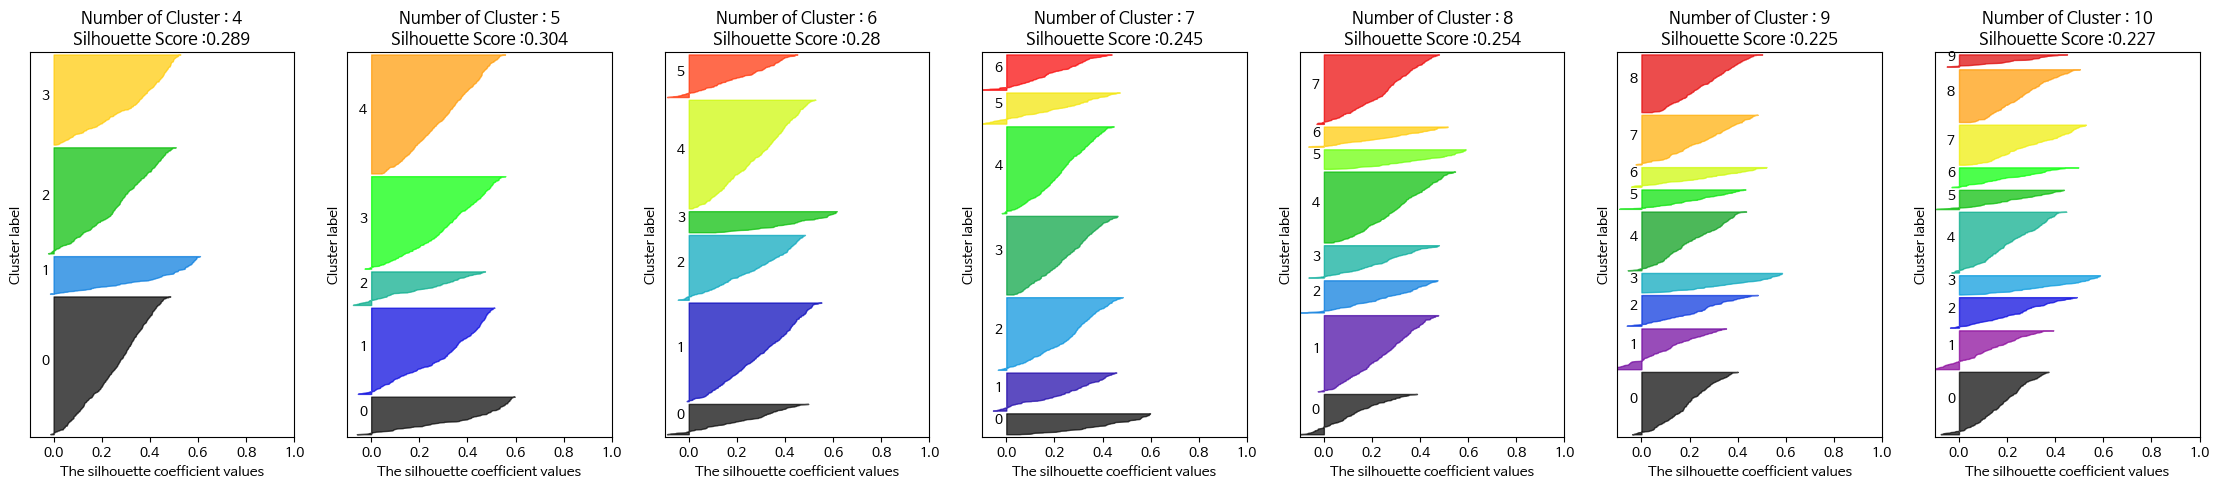

In [101]:
visualize_silhouette([4, 5, 6, 7, 8, 9, 10], log_features_df)

---
# IQR 이상치 제외 + Kmeans
- https://hwi-doc.tistory.com/entry/IQR-%EB%B0%A9%EC%8B%9D%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%9D%B4%EC%83%81%EC%B9%98-%EB%8D%B0%EC%9D%B4%ED%84%B0Outlier-%EC%A0%9C%EA%B1%B0
- 총결제금액 기준으로 이상치 선정
- 제외한 이상치를 하위 그룹, 상위 그룹 2개로 별도 구분

In [102]:
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight

  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight

  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx, lowest, highest

# 함수 사용해서 이상치 값 삭제
outlier_idx, low, high = get_outlier(df=new_features_df, column='총결제금액', weight=1.5)
new_features_drop_iqr = new_features_df.drop(outlier_idx, axis=0)

In [103]:
low, high

(-4623.14625, 9611.24375)

- 총결제금액에서 -4623.14625 값은 존재하지 않으므로 하위 그룹은 없다고 보아야 함

In [104]:
new_features_drop_iqr.describe()

최초거래날짜       최근거래날짜         구매횟수        구매제품수          구매원가  \
count  1368.000000  1368.000000  1368.000000  1368.000000   1368.000000   
mean    206.151316   150.369883    13.703947   112.125731   2490.940263   
std     104.531762   101.717989    12.049250   155.027016   2342.555282   
min       1.000000     1.000000     1.000000     1.000000      1.100000   
25%     127.000000    62.000000     5.000000    17.000000    665.585000   
50%     215.500000   137.000000    10.000000    53.000000   1763.100000   
75%     290.000000   223.000000    20.000000   144.000000   3680.255000   
max     365.000000   365.000000    69.000000  1202.000000  10875.750000   

               할인가          배송료        총결제금액  
count  1368.000000  1368.000000  1368.000000  
mean   2320.874693   122.307142  2443.181835  
std    2184.788053   117.051875  2284.447601  
min       0.990000     6.000000     6.990000  
25%     615.725000    36.000000   659.567500  
50%    1615.780000    86.365000  1718.385000  
75%    3402.367500   172.715000  3599.787500  
max    9363.590000   868.650000  9551.460000

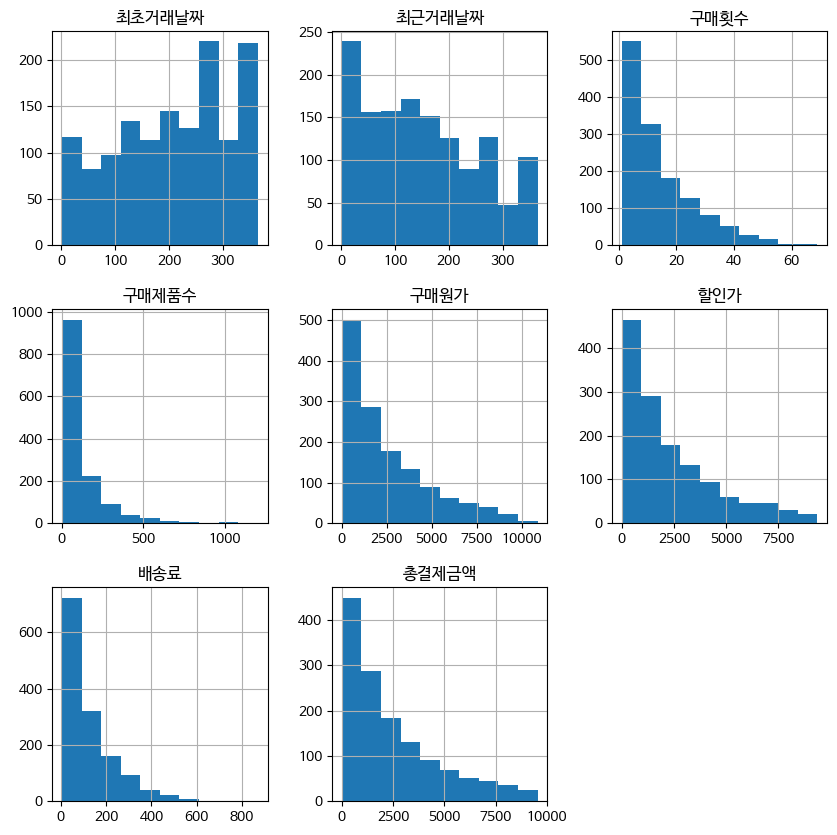

In [105]:
new_features_drop_iqr.hist(figsize=(10, 10));

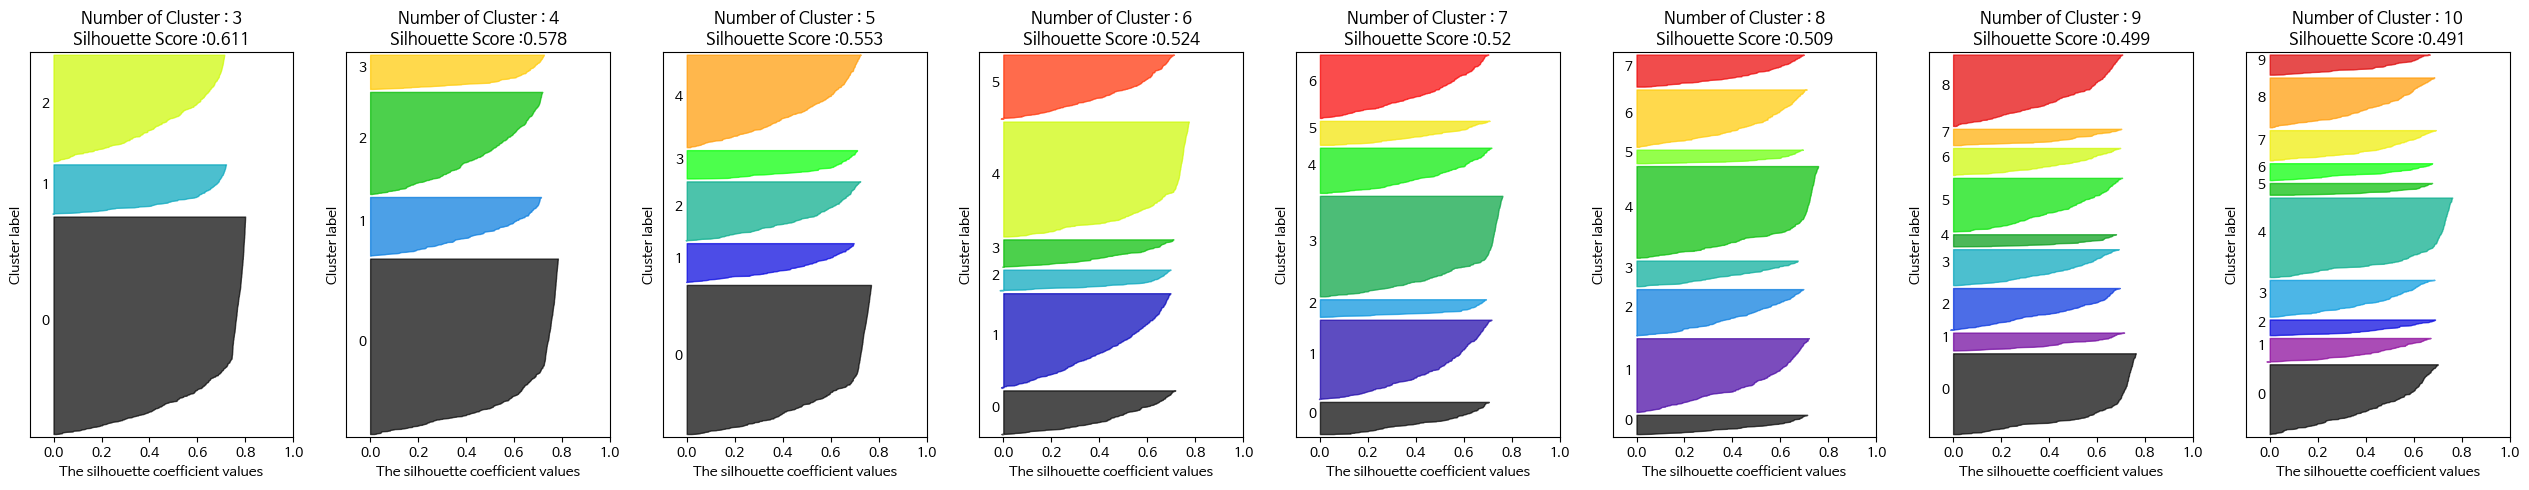

In [106]:
new_features_drop_iqr_labels = visualize_silhouette([3, 4, 5, 6, 7, 8, 9, 10], new_features_drop_iqr)

In [107]:
new_features_drop_iqr_labels[4]

array([0, 2, 0, ..., 0, 0, 3], dtype=int32)

## Cluster 0 한 번 더 쪼개기
- 현재 이상치 1개 + 4개 Clustered Group



In [108]:
new_features_drop_iqr_cluster = new_features_drop_iqr.copy()
new_features_drop_iqr_cluster['Cluster'] = new_features_drop_iqr_labels[4]
new_features_drop_iqr_cluster

최초거래날짜  최근거래날짜  구매횟수  구매제품수     구매원가      할인가     배송료    총결제금액  Cluster
0        108     108     1      3    35.69    24.98   75.00    99.98        0
2        193      74     8    209  1645.73  1492.42   81.07  1573.49        2
3         18      18    11     21  1508.36  1339.57   82.39  1421.96        0
4        108     108    13     56  1594.23  1369.93  154.49  1524.42        0
5        131     131     3     86   696.47   688.02   18.00   706.02        0
...      ...     ...   ...    ...      ...      ...     ...      ...      ...
1463     271     271     3     46   595.58   582.38   94.35   676.73        0
1464     193      88    19    141  2640.23  2384.13  222.05  2606.18        2
1465     271     195     2     10   119.58   115.40   12.50   127.90        0
1466      70      70     1      2   327.80   327.80    6.00   333.80        0
1467     156      83    53    155  6946.00  6639.16  337.87  6977.03        3

[1368 rows x 9 columns]

In [109]:
new_features_drop_iqr_cluster_0 = new_features_drop_iqr_cluster[new_features_drop_iqr_cluster['Cluster'] == 0]
new_features_drop_iqr_cluster_0

최초거래날짜  최근거래날짜  구매횟수  구매제품수     구매원가      할인가     배송료    총결제금액  Cluster
0        108     108     1      3    35.69    24.98   75.00    99.98        0
3         18      18    11     21  1508.36  1339.57   82.39  1421.96        0
4        108     108    13     56  1594.23  1369.93  154.49  1524.42        0
5        131     131     3     86   696.47   688.02   18.00   706.02        0
7         25      25     5     22   526.96   492.60   38.48   531.08        0
...      ...     ...   ...    ...      ...      ...     ...      ...      ...
1458     109     109     1     50   109.45    76.61    6.00    82.61        0
1462     180     180     2      4    58.35    58.35   12.50    70.85        0
1463     271     271     3     46   595.58   582.38   94.35   676.73        0
1465     271     195     2     10   119.58   115.40   12.50   127.90        0
1466      70      70     1      2   327.80   327.80    6.00   333.80        0

[647 rows x 9 columns]

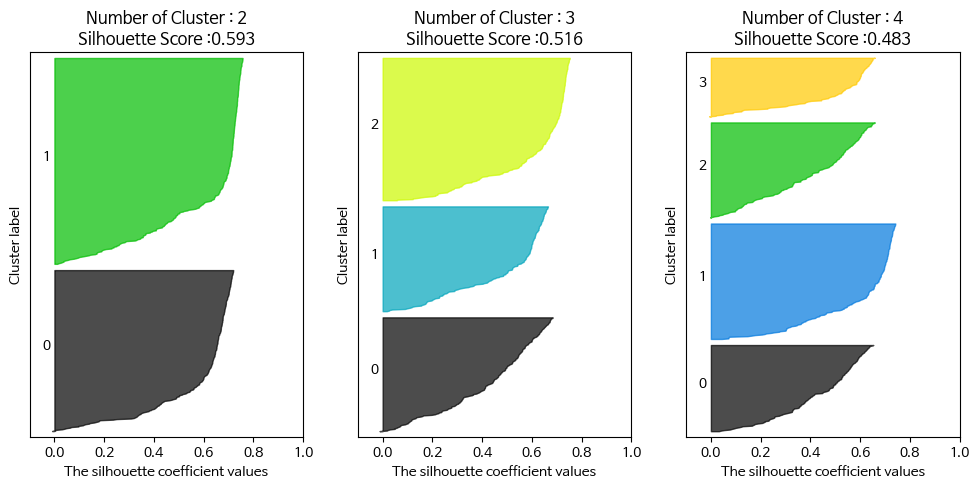

In [110]:
new_features_drop_iqr_cluster_0_labels = visualize_silhouette([2, 3, 4], new_features_drop_iqr_cluster_0)

In [111]:
new_features_drop_iqr_cluster_0['Cluster'] = new_features_drop_iqr_cluster_0_labels[2]
new_features_drop_iqr_cluster_0['Cluster'].replace({0:4, 1:5}, inplace=True)
new_features_drop_iqr_cluster_0

<ipython-input-111-23fe19f8e061>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_features_drop_iqr_cluster_0['Cluster'] = new_features_drop_iqr_cluster_0_labels[2]
<ipython-input-111-23fe19f8e061>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_features_drop_iqr_cluster_0['Cluster'].replace({0:4, 1:5}, inplace=True)


최초거래날짜  최근거래날짜  구매횟수  구매제품수     구매원가      할인가     배송료    총결제금액  Cluster
0        108     108     1      3    35.69    24.98   75.00    99.98        5
3         18      18    11     21  1508.36  1339.57   82.39  1421.96        4
4        108     108    13     56  1594.23  1369.93  154.49  1524.42        4
5        131     131     3     86   696.47   688.02   18.00   706.02        4
7         25      25     5     22   526.96   492.60   38.48   531.08        5
...      ...     ...   ...    ...      ...      ...     ...      ...      ...
1458     109     109     1     50   109.45    76.61    6.00    82.61        5
1462     180     180     2      4    58.35    58.35   12.50    70.85        5
1463     271     271     3     46   595.58   582.38   94.35   676.73        5
1465     271     195     2     10   119.58   115.40   12.50   127.90        5
1466      70      70     1      2   327.80   327.80    6.00   333.80        5

[647 rows x 9 columns]

In [112]:
for idx in new_features_drop_iqr_cluster_0.index:
  new_features_drop_iqr_cluster.loc[idx, 'Cluster'] = new_features_drop_iqr_cluster_0.loc[idx, 'Cluster']

new_features_drop_iqr_cluster

최초거래날짜  최근거래날짜  구매횟수  구매제품수     구매원가      할인가     배송료    총결제금액  Cluster
0        108     108     1      3    35.69    24.98   75.00    99.98        5
2        193      74     8    209  1645.73  1492.42   81.07  1573.49        2
3         18      18    11     21  1508.36  1339.57   82.39  1421.96        4
4        108     108    13     56  1594.23  1369.93  154.49  1524.42        4
5        131     131     3     86   696.47   688.02   18.00   706.02        4
...      ...     ...   ...    ...      ...      ...     ...      ...      ...
1463     271     271     3     46   595.58   582.38   94.35   676.73        5
1464     193      88    19    141  2640.23  2384.13  222.05  2606.18        2
1465     271     195     2     10   119.58   115.40   12.50   127.90        5
1466      70      70     1      2   327.80   327.80    6.00   333.80        5
1467     156      83    53    155  6946.00  6639.16  337.87  6977.03        3

[1368 rows x 9 columns]

## 이상치 그룹을 6으로 추가하기
- 이상치 1개 + clustered group 6개


In [113]:
new_features_df_high = new_features_df[new_features_df['총결제금액'] >= high]
new_features_df_high['Cluster'] = [6] * len(new_features_df_high)
new_features_df_high

<ipython-input-113-7da481146b72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_features_df_high['Cluster'] = [6] * len(new_features_df_high)


최초거래날짜  최근거래날짜  구매횟수  구매제품수      구매원가       할인가      배송료     총결제금액  \
1        283      60    31    342  15902.78  15021.67   286.46  15308.13   
8        180      41    37    421  10842.99  10473.22   334.50  10807.72   
26       357     266    55   1494  15444.70  15042.48  1290.23  16332.71   
30       104     104    57    799  10854.35   9775.49   526.07  10301.56   
33       348      16    70    279  15345.18  14486.54   567.16  15053.70   
...      ...     ...   ...    ...       ...       ...      ...       ...   
1397     278      20    35   1397  13640.28  13170.16   320.93  13491.09   
1411     347      19    95    716  15743.19  14979.30  1004.99  15984.29   
1432     249     169    77    374  11892.47  11383.12   514.16  11897.28   
1433     320     107   120   1230  21261.91  19923.70  1214.95  21138.65   
1435      50      49    45    165  11860.05  10761.71   353.73  11115.44   

      Cluster  
1           6  
8           6  
26          6  
30          6  
33          6  
...       ...  
1397        6  
1411        6  
1432        6  
1433        6  
1435        6  

[100 rows x 9 columns]

In [114]:
iqr_df = pd.concat([new_features_drop_iqr_cluster, new_features_df_high], axis=0).sort_index()
iqr_df

최초거래날짜  최근거래날짜  구매횟수  구매제품수      구매원가       할인가     배송료     총결제금액  \
0        108     108     1      3     35.69     24.98   75.00     99.98   
1        283      60    31    342  15902.78  15021.67  286.46  15308.13   
2        193      74     8    209   1645.73   1492.42   81.07   1573.49   
3         18      18    11     21   1508.36   1339.57   82.39   1421.96   
4        108     108    13     56   1594.23   1369.93  154.49   1524.42   
...      ...     ...   ...    ...       ...       ...     ...       ...   
1463     271     271     3     46    595.58    582.38   94.35    676.73   
1464     193      88    19    141   2640.23   2384.13  222.05   2606.18   
1465     271     195     2     10    119.58    115.40   12.50    127.90   
1466      70      70     1      2    327.80    327.80    6.00    333.80   
1467     156      83    53    155   6946.00   6639.16  337.87   6977.03   

      Cluster  
0           5  
1           6  
2           2  
3           4  
4           4  
...       ...  
1463        5  
1464        2  
1465        5  
1466        5  
1467        3  

[1468 rows x 9 columns]

- 총 6개 그룹으로 구분

In [115]:
iqr_df = pd.concat([customer_buyinginfo_df, iqr_df['Cluster']], axis=1)
iqr_df

고객ID  가입날짜  최초거래날짜  최근거래날짜  구매횟수  구매제품수      구매원가       할인가  \
0     USER_0000   988     108     108     1      3     35.69     24.98   
1     USER_0001   659     283      60    31    342  15902.78  15021.67   
2     USER_0002  1205     193      74     8    209   1645.73   1492.42   
3     USER_0003   764      18      18    11     21   1508.36   1339.57   
4     USER_0004   988     108     108    13     56   1594.23   1369.93   
...         ...   ...     ...     ...   ...    ...       ...       ...   
1463  USER_1463   183     271     271     3     46    595.58    582.38   
1464  USER_1464  1352     193      88    19    141   2640.23   2384.13   
1465  USER_1465   764     271     195     2     10    119.58    115.40   
1466  USER_1466  1499      70      70     1      2    327.80    327.80   
1467  USER_1467  1093     156      83    53    155   6946.00   6639.16   

         배송료     총결제금액  평균결제금액  평균할인차액  평균할인비율  구매제품평균금액  Cluster  
0      75.00     99.98   99.98  -10.71    0.11      8.33        5  
1     286.46  15308.13  493.81  -28.42    0.06     43.92        6  
2      81.07   1573.49  196.69  -19.16    0.10      7.14        2  
3      82.39   1421.96  129.27  -15.34    0.12     63.79        4  
4     154.49   1524.42  117.26  -17.25    0.15     24.46        4  
...      ...       ...     ...     ...     ...       ...      ...  
1463   94.35    676.73  225.58   -4.40    0.02     12.66        5  
1464  222.05   2606.18  137.17  -13.48    0.10     16.91        2  
1465   12.50    127.90   63.95   -2.09    0.03     11.54        5  
1466    6.00    333.80  333.80    0.00    0.00    163.90        5  
1467  337.87   6977.03  131.64   -5.79    0.04     42.83        3  

[1468 rows x 15 columns]

---
# 8개 Features PCA + Kmeans
- 2차원으로 축소

In [116]:
from sklearn.decomposition import PCA

# PCA 변환
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(new_features_df)
pca_df = pd.DataFrame(data=principalComponents, columns=['1st', '2nd'])
pca_df

1st         2nd
0     -5852.953742    9.100289
1     20749.573291  385.916257
2     -3219.465087  -44.187432
3     -3479.577942  153.578519
4     -3349.645598   71.818550
...            ...         ...
1463  -4874.143900 -115.562288
1464  -1532.503263    3.583816
1465  -5737.754685  -46.268029
1466  -5376.986760   63.813297
1467   5930.313611   67.494975

[1468 rows x 2 columns]

In [117]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette_2d(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 8), nrows=2, ncols=n_cols)

    # cluster label 추출
    labels = {}

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=13)
        cluster_labels = clusterer.fit_predict(X_features)
        labels[n_cluster] = cluster_labels
        centers = clusterer.cluster_centers_

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[0, ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[0, ind].set_xlabel("The silhouette coefficient values")
        axs[0, ind].set_ylabel("Cluster label")
        axs[0, ind].set_xlim([-0.1, 1])
        axs[0, ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[0, ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[0, ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[0, ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[0, ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        #     클러스터링된 데이터 시각화
            axs[1,ind].scatter(X_features.iloc[:, 0], X_features.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7, \
                c=cluster_labels)
            axs[1,ind].set_title("Clustered data")
            axs[1,ind].set_xlabel("Feature space for the 1st feature")
            axs[1,ind].set_ylabel("Feature space for the 2nd feature")

        # 군집별 중심 위치 좌표 시각화
        unique_labels = np.unique(cluster_labels)
        for label in unique_labels:
            center_x_y = centers[label]
            axs[1,ind].scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k',
                        marker='$%d$' % label)

        axs[0,ind].axvline(x=sil_avg, color="red", linestyle="--")

    plt.tight_layout()

    return labels

{4: array([0, 1, 0, ..., 0, 0, 2], dtype=int32),
 5: array([0, 1, 0, ..., 0, 0, 3], dtype=int32),
 6: array([1, 2, 1, ..., 1, 1, 0], dtype=int32),
 7: array([0, 2, 0, ..., 0, 0, 3], dtype=int32),
 8: array([2, 3, 2, ..., 2, 2, 7], dtype=int32)}

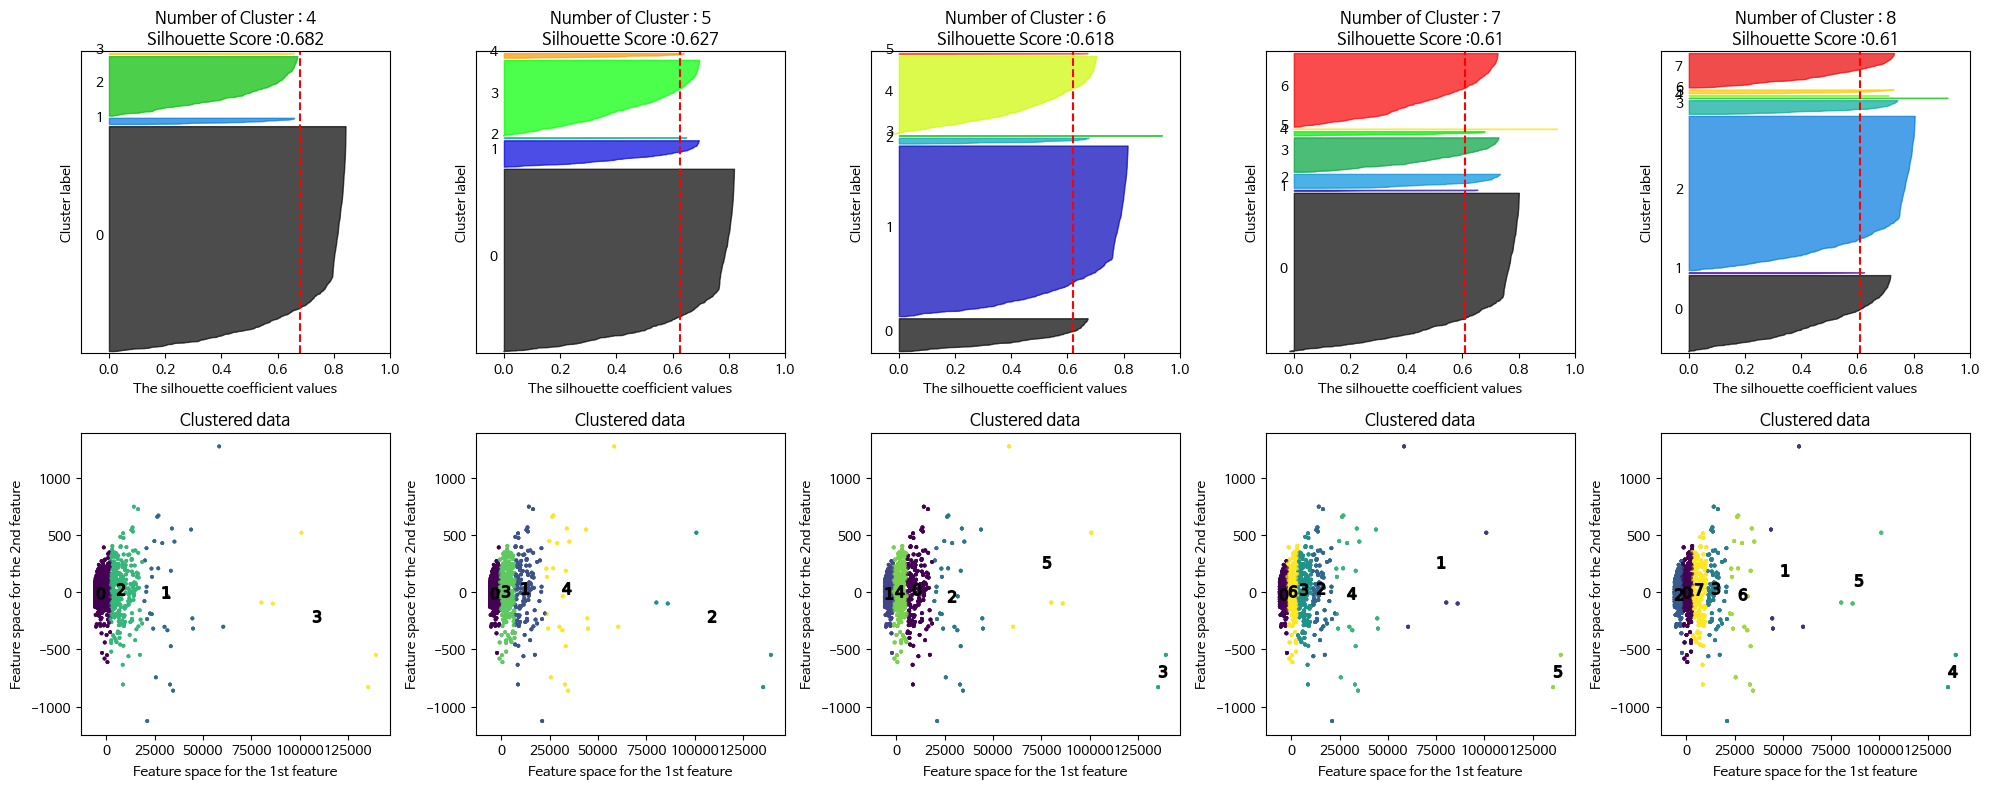

In [118]:
# cluster 개수를 2개, 3개, 4개, 5개, 6개, 7개 일때의 클러스터별 실루엣 계수 평균값을 시각화
visualize_silhouette_2d([4, 5, 6, 7, 8], pca_df)

- rs, ss, mm 스케일러 적용한 값 보다 스케일러 미적용이 클러스터링에 더 효과적이었음

---
# 이상치 제거 + 5개 Features PCA + Kmeans + Normalize -> df
- 2차원으로 축소

In [119]:
features5 = customer_buyinginfo_df.copy()
features5_df = features5[['최초거래날짜', '최근거래날짜', '구매횟수', '구매제품수', '총결제금액']]
features5_df.head()

최초거래날짜  최근거래날짜  구매횟수  구매제품수     총결제금액
0     108     108     1      3     99.98
1     283      60    31    342  15308.13
2     193      74     8    209   1573.49
3      18      18    11     21   1421.96
4     108     108    13     56   1524.42

<Axes: >

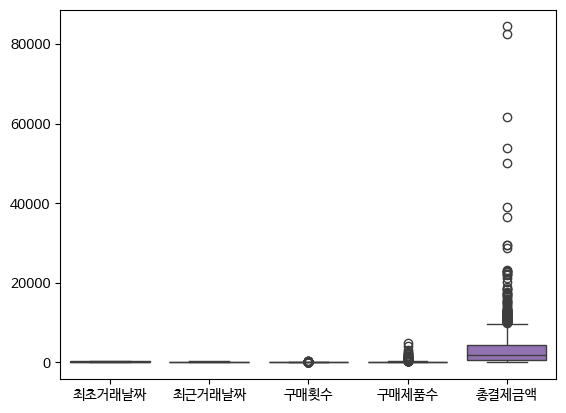

In [168]:
sns.boxplot(features5_df)

In [120]:
# 함수 사용해서 이상치 값 삭제
outlier_idx, low, high = get_outlier(df=features5_df, column='총결제금액', weight=1.5)
features5_drop_iqr = features5_df.drop(outlier_idx, axis=0)

<Axes: >

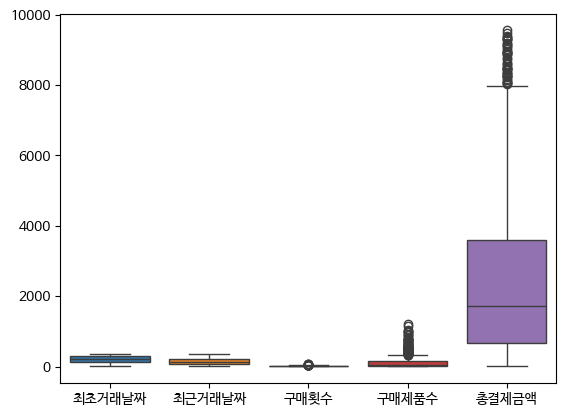

In [169]:
sns.boxplot(features5_drop_iqr)

In [121]:
low, high

(-4623.14625, 9611.24375)

In [122]:
normalized_df = (features5_drop_iqr-features5_drop_iqr.mean())/features5_drop_iqr.std()
normalized_df

최초거래날짜    최근거래날짜      구매횟수     구매제품수     총결제금액
0    -0.938962 -0.416543 -1.054335 -0.703914 -1.025719
2    -0.125812 -0.750800 -0.473386  0.624886 -0.380701
3    -1.799944 -1.301342 -0.224408 -0.587805 -0.447032
4    -0.938962 -0.416543 -0.058423 -0.362038 -0.402181
5    -0.718933 -0.190427 -0.888350 -0.168524 -0.760430
...        ...       ...       ...       ...       ...
1463  0.620373  1.185927 -0.888350 -0.426543 -0.773251
1464 -0.125812 -0.613165  0.439534  0.186253  0.071351
1465  0.620373  0.438763 -0.971342 -0.658761 -1.013497
1466 -1.302488 -0.790125 -1.054335 -0.710365 -0.923366
1467 -0.479771 -0.662320  3.261286  0.276560  1.984658

[1368 rows x 5 columns]

In [166]:
# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(features5_df)
# pca_drop_iqr_df = pd.DataFrame(data=principalComponents, columns=['1st', '2nd'])
# pca_drop_iqr_df

1st         2nd
0     -3364.284415  -21.566809
1     11842.558674 -390.833298
2     -1881.967159  114.729545
3     -2042.988002 -104.310483
4     -1938.947453  -38.251210
...            ...         ...
1463  -2786.177266   60.224125
1464   -853.940377    4.138146
1465  -3335.823333   34.999341
1466  -3130.791902  -49.372407
1467   3512.182328 -197.206928

[1468 rows x 2 columns]

In [123]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_df)
pca_drop_iqr_df = pd.DataFrame(data=principalComponents, columns=['1st', '2nd'])
pca_drop_iqr_df

1st       2nd
0    -1.683657 -0.909608
1    -0.139962 -0.558409
2    -0.805334 -2.187121
3    -0.542870 -0.951921
4    -1.150177 -0.584419
...        ...       ...
1363 -1.249531  1.318083
1364  0.443220 -0.532572
1365 -1.484245  0.787369
1366 -1.634686 -1.434068
1367  3.283831 -0.985684

[1368 rows x 2 columns]

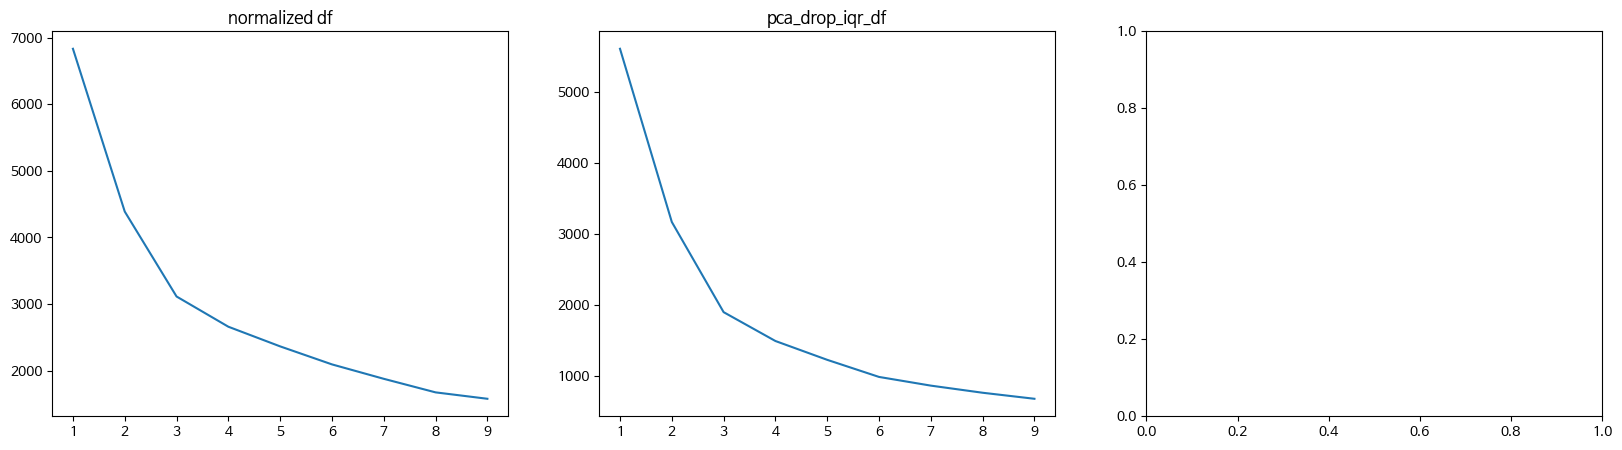

In [163]:
# elbow point: 엘보우 포인트는 클러스터의 수가 증가함에 따라 클러스터 내 오차 제곱합(SSE: Sum of Squared Errors)이 어떻게 변하는지를 보여줌. 엘보우 포인트는 SSE의 감소율이 급격하게 줄어드는 지점으로, 이 지점에서는 클러스터의 수를 증가시켜도 성능이 크게 향상되지 않는다는 것을 의미
from sklearn.cluster import KMeans

point = {}
pca_point = {}

for k in range(1, 10):
  kmeans = KMeans(n_clusters=k, max_iter=100).fit(normalized_df)
  # normalized_df['kmeans cluster'] = kmeans.labels_
  point[k] = kmeans.inertia_

  kmeans = KMeans(n_clusters=k, max_iter=100).fit(pca_drop_iqr_df)
  # normalized_df['kmeans cluster'] = kmeans.labels_
  pca_point[k] = kmeans.inertia_

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

ax0 = sns.lineplot(ax=axes[0], x=list(point.keys()), y=list(point.values()))
ax0.set_title('normalized df')

ax1 = sns.lineplot(ax=axes[1], x=list(pca_point.keys()), y=list(pca_point.values()))
ax1.set_title('pca_drop_iqr_df')

plt.show()

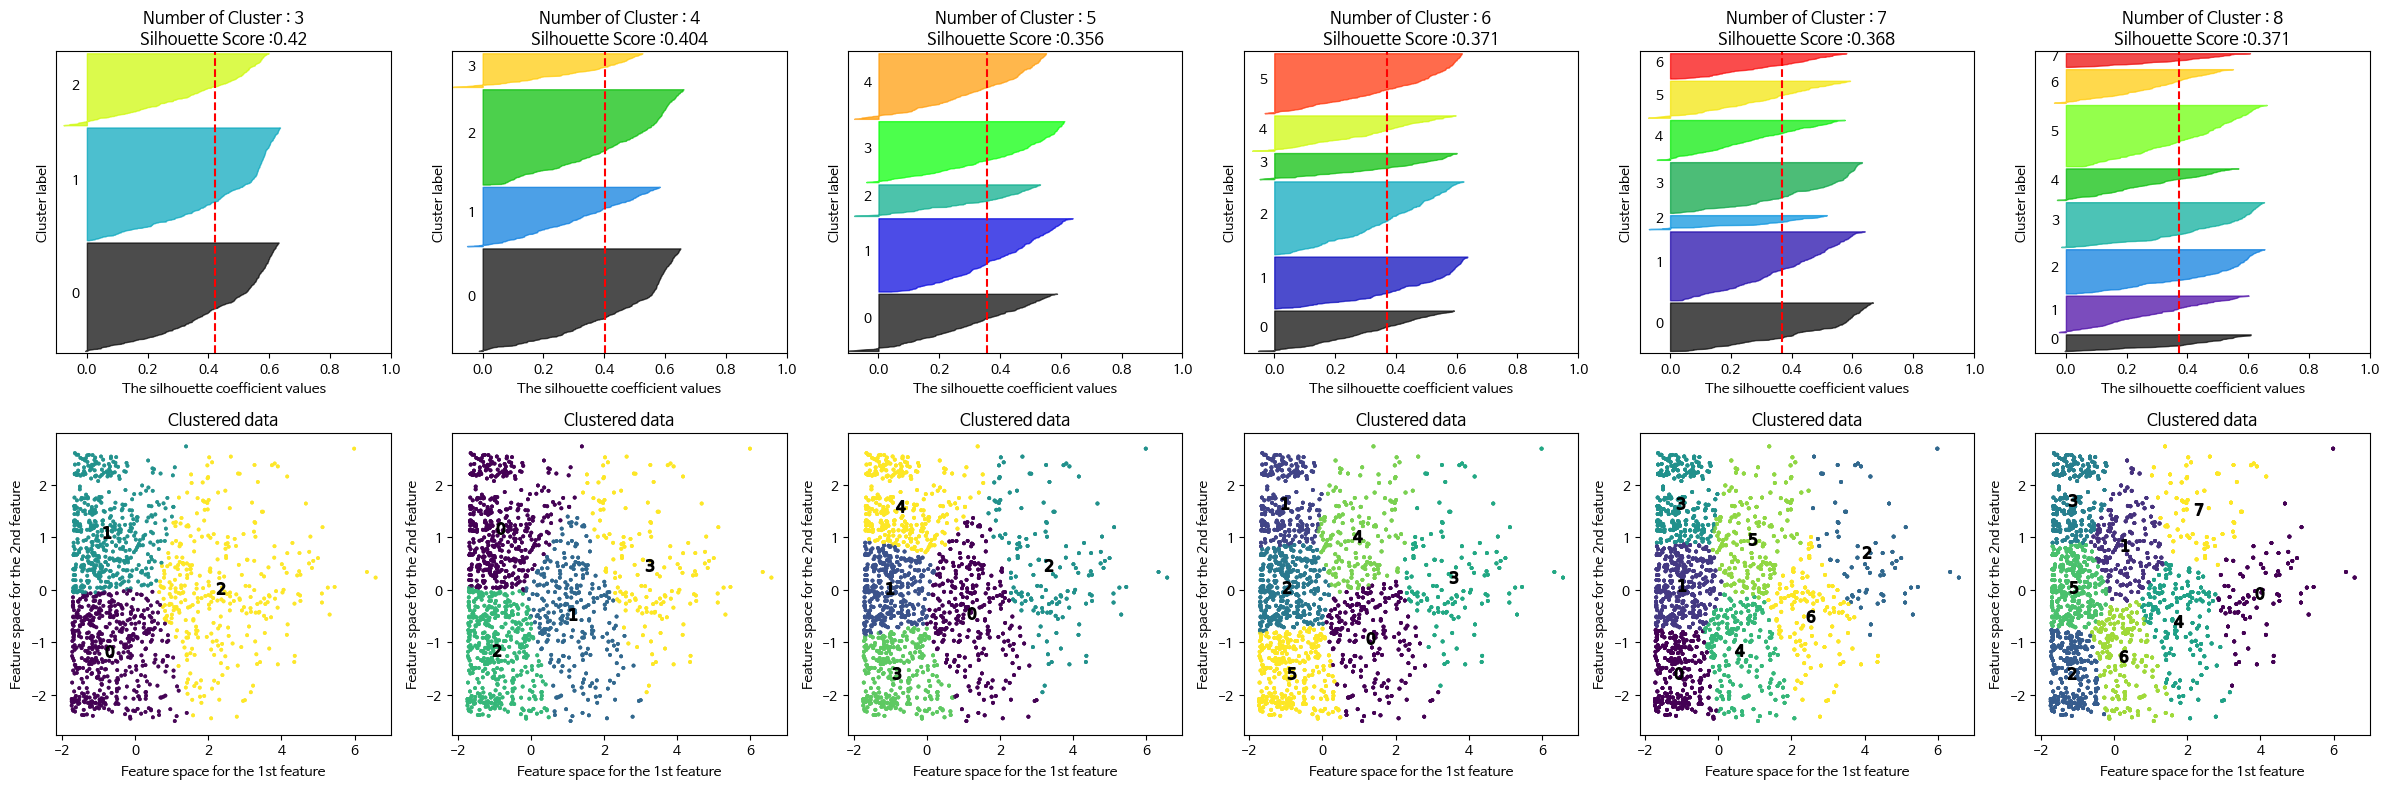

In [164]:
pca_drop_iqr_df_labels = visualize_silhouette_2d([3, 4, 5, 6, 7, 8], pca_drop_iqr_df)

In [125]:
pca_drop_iqr_cluster = features5_drop_iqr.copy()
pca_drop_iqr_cluster['Cluster'] = pca_drop_iqr_df_labels[6]
pca_drop_iqr_cluster

최초거래날짜  최근거래날짜  구매횟수  구매제품수    총결제금액  Cluster
0        108     108     1      3    99.98        5
2        193      74     8    209  1573.49        2
3         18      18    11     21  1421.96        5
4        108     108    13     56  1524.42        5
5        131     131     3     86   706.02        2
...      ...     ...   ...    ...      ...      ...
1463     271     271     3     46   676.73        1
1464     193      88    19    141  2606.18        0
1465     271     195     2     10   127.90        2
1466      70      70     1      2   333.80        5
1467     156      83    53    155  6977.03        3

[1368 rows x 6 columns]

## 이상치 그룹을 6으로 추가하기. 총 7개
- 이상치 1개 + clustered group 6개


In [126]:
features5_df_high = features5_df[features5_df['총결제금액'] >= 9611.24375]
features5_df_high['Cluster'] = [6] * len(features5_df_high)
features5_df_high

<ipython-input-126-2702df5692f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features5_df_high['Cluster'] = [6] * len(features5_df_high)


최초거래날짜  최근거래날짜  구매횟수  구매제품수     총결제금액  Cluster
1        283      60    31    342  15308.13        6
8        180      41    37    421  10807.72        6
26       357     266    55   1494  16332.71        6
30       104     104    57    799  10301.56        6
33       348      16    70    279  15053.70        6
...      ...     ...   ...    ...       ...      ...
1397     278      20    35   1397  13491.09        6
1411     347      19    95    716  15984.29        6
1432     249     169    77    374  11897.28        6
1433     320     107   120   1230  21138.65        6
1435      50      49    45    165  11115.44        6

[100 rows x 6 columns]

In [127]:
pca_iqr_df = pd.concat([pca_drop_iqr_cluster, features5_df_high], axis=0).sort_index()
pca_iqr_df

최초거래날짜  최근거래날짜  구매횟수  구매제품수     총결제금액  Cluster
0        108     108     1      3     99.98        5
1        283      60    31    342  15308.13        6
2        193      74     8    209   1573.49        2
3         18      18    11     21   1421.96        5
4        108     108    13     56   1524.42        5
...      ...     ...   ...    ...       ...      ...
1463     271     271     3     46    676.73        1
1464     193      88    19    141   2606.18        0
1465     271     195     2     10    127.90        2
1466      70      70     1      2    333.80        5
1467     156      83    53    155   6977.03        3

[1468 rows x 6 columns]

In [128]:
pca_iqr_df = pd.concat([customer_buyinginfo_df, pca_iqr_df['Cluster']], axis=1)
pca_iqr_df

고객ID  가입날짜  최초거래날짜  최근거래날짜  구매횟수  구매제품수      구매원가       할인가  \
0     USER_0000   988     108     108     1      3     35.69     24.98   
1     USER_0001   659     283      60    31    342  15902.78  15021.67   
2     USER_0002  1205     193      74     8    209   1645.73   1492.42   
3     USER_0003   764      18      18    11     21   1508.36   1339.57   
4     USER_0004   988     108     108    13     56   1594.23   1369.93   
...         ...   ...     ...     ...   ...    ...       ...       ...   
1463  USER_1463   183     271     271     3     46    595.58    582.38   
1464  USER_1464  1352     193      88    19    141   2640.23   2384.13   
1465  USER_1465   764     271     195     2     10    119.58    115.40   
1466  USER_1466  1499      70      70     1      2    327.80    327.80   
1467  USER_1467  1093     156      83    53    155   6946.00   6639.16   

         배송료     총결제금액  평균결제금액  평균할인차액  평균할인비율  구매제품평균금액  Cluster  
0      75.00     99.98   99.98  -10.71    0.11      8.33        5  
1     286.46  15308.13  493.81  -28.42    0.06     43.92        6  
2      81.07   1573.49  196.69  -19.16    0.10      7.14        2  
3      82.39   1421.96  129.27  -15.34    0.12     63.79        5  
4     154.49   1524.42  117.26  -17.25    0.15     24.46        5  
...      ...       ...     ...     ...     ...       ...      ...  
1463   94.35    676.73  225.58   -4.40    0.02     12.66        1  
1464  222.05   2606.18  137.17  -13.48    0.10     16.91        0  
1465   12.50    127.90   63.95   -2.09    0.03     11.54        2  
1466    6.00    333.80  333.80    0.00    0.00    163.90        5  
1467  337.87   6977.03  131.64   -5.79    0.04     42.83        3  

[1468 rows x 15 columns]

---
# RMF Cluster

In [129]:
# 2019년 말일 기준으로 최근 거래일을 일로 환산하기
today = datetime.date(2019, 12, 31)

rfm_df = customer_buyinginfo_df[['최근거래날짜', '구매횟수', '총결제금액']].copy()
rfm_df.columns = ['R', 'F', 'M']
rfm_df


R   F         M
0     108   1     99.98
1      60  31  15308.13
2      74   8   1573.49
3      18  11   1421.96
4     108  13   1524.42
...   ...  ..       ...
1463  271   3    676.73
1464   88  19   2606.18
1465  195   2    127.90
1466   70   1    333.80
1467   83  53   6977.03

[1468 rows x 3 columns]

In [130]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(rfm_df)
rfm_df['Cluster'] = kmeans.predict(rfm_df)
rfm_df

R   F         M  Cluster
0     108   1     99.98        1
1      60  31  15308.13        2
2      74   8   1573.49        1
3      18  11   1421.96        1
4     108  13   1524.42        1
...   ...  ..       ...      ...
1463  271   3    676.73        1
1464   88  19   2606.18        1
1465  195   2    127.90        1
1466   70   1    333.80        1
1467   83  53   6977.03        4

[1468 rows x 4 columns]

In [131]:
rfm_df.groupby('Cluster').describe().T

Cluster             0            1             2             3            4
R count     26.000000   905.000000    149.000000      5.000000   383.000000
  mean      83.423077   163.602210     97.469799     30.200000   126.334204
  std       92.384489   100.082327     93.076586     43.928351    98.922086
  min        2.000000     1.000000      4.000000      1.000000     1.000000
  25%       23.250000    81.000000     32.000000     11.000000    41.500000
  50%       48.500000   153.000000     61.000000     13.000000   102.000000
  75%      110.000000   240.000000    138.000000     18.000000   193.000000
  max      340.000000   365.000000    363.000000    108.000000   362.000000
F count     26.000000   905.000000    149.000000      5.000000   383.000000
  mean      93.038462     6.861878     48.536913    289.400000    24.342037
  std       42.085133     4.740120     16.470089     24.337214     8.369446
  min       24.000000     1.000000      4.000000    263.000000     2.000000
  25%       60.500000     3.000000     38.000000    276.000000    18.000000
  50%       91.500000     6.000000     46.000000    289.000000    24.000000
  75%      119.250000    10.000000     59.000000    291.000000    30.000000
  max      177.000000    23.000000     99.000000    328.000000    53.000000
M count     26.000000   905.000000    149.000000      5.000000   383.000000
  mean   22321.573462  1072.433923   9960.150067  66491.270000  4470.735822
  std     5952.065321   784.502072   2170.041371  16007.183636  1227.012337
  min    16332.710000     6.990000   7239.190000  50110.170000  2767.720000
  25%    17960.645000   374.280000   8138.410000  53883.430000  3403.620000
  50%    21576.545000   967.740000   9305.990000  61651.340000  4239.610000
  75%    22982.292500  1691.380000  11482.700000  82405.580000  5403.705000
  max    39126.840000  2762.740000  15984.290000  84405.830000  7127.250000

In [132]:
tmp_df = rfm_df.groupby('Cluster').mean()
tmp_df

R           F             M
Cluster                                      
0         83.423077   93.038462  22321.573462
1        163.602210    6.861878   1072.433923
2         97.469799   48.536913   9960.150067
3         30.200000  289.400000  66491.270000
4        126.334204   24.342037   4470.735822

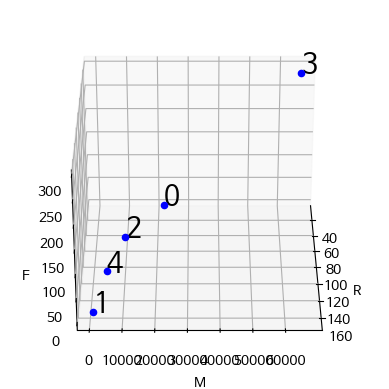

In [133]:
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
from matplotlib import animation

tmp_df = rfm_df.groupby('Cluster').mean()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(tmp_df)): # plot each point + it's index as text above
  x = tmp_df['R'][i]
  y = tmp_df['M'][i]
  z = tmp_df['F'][i]
  label = i
  ax.scatter(x, y, z, color='b')
  ax.text(x, y, z, '%s' % (label), size=20, zorder=1, color='k')

ax.set_xlabel('R')
ax.set_ylabel('M')
ax.set_zlabel('F')

def animate(frame):
  ax.view_init(30, frame/4)
  plt.pause(.001)
  return fig

anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
HTML(anim.to_html5_video())

{4: array([0, 1, 0, ..., 0, 0, 3], dtype=int32),
 5: array([0, 3, 0, ..., 0, 0, 4], dtype=int32),
 6: array([1, 2, 1, ..., 1, 1, 0], dtype=int32),
 7: array([6, 3, 6, ..., 6, 6, 0], dtype=int32),
 8: array([3, 7, 3, ..., 3, 3, 5], dtype=int32)}

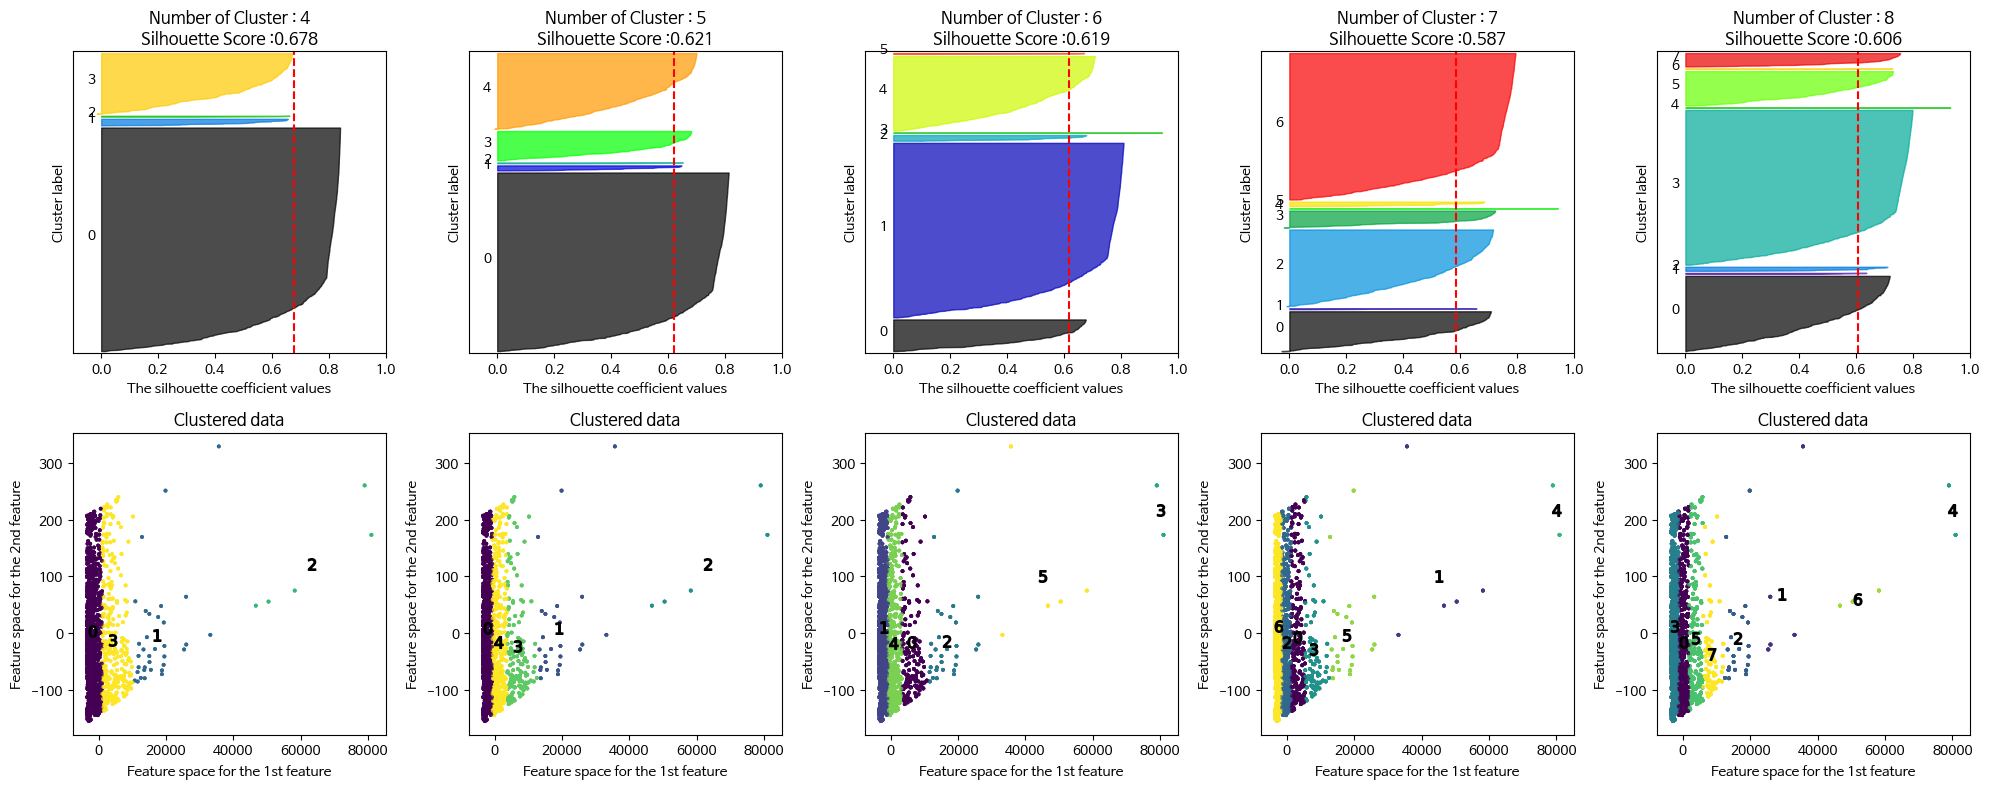

In [134]:
# cluster 개수를 2개, 3개, 4개, 5개, 6개, 7개 일때의 클러스터별 실루엣 계수 평균값을 시각화
from sklearn.decomposition import PCA

# PCA 변환
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(rfm_df.drop('Cluster', axis=1))
rfm_pca_df = pd.DataFrame(data=principalComponents, columns=['1st', '2nd'])
rfm_pca_df

visualize_silhouette_2d([4, 5, 6, 7, 8], rfm_pca_df)

---

# 8 features PCA + SS + DBSCAN -> df

- K-means 알고리즘은 평균을 취하기 때문에 이상치에 민감하며, DBSCAN은 잡음점을 식별하므로 이상치에 민감하지 않다(robust).

- 클러스터링 과정 구현<br>
DBSCAN은 feature 간 거리를 기준으로 클러스터를 구성하는 알고리즘으로,이 과정을 위해서는 정규화가 필수적입니다.
DBSCAN 군집화를 위해서는 현재 군집 상태로부터 최대 탐색 거리를 의미하는 epsilon 값(반지름)과 클러스터로 구성되기 위한 최소 샘플 개수인 min_samples 값을 지정해주어야 합니다.

In [135]:
pca_df.head(2)

1st         2nd
0  -5852.953742    9.100289
1  20749.573291  385.916257

In [136]:
ss_pca_df = pd.DataFrame(ss.fit_transform(pca_df))
ss_pca_df.head(2)

0         1
0 -0.615507  0.057450
1  2.182062  2.436296

In [137]:
from sklearn.cluster import DBSCAN

# create model and prediction
dbscan = DBSCAN(eps=0.6, min_samples=10)
cluster = pd.DataFrame(dbscan.fit_predict(ss_pca_df))
cluster.columns=['Cluster']

# concatenate labels to df as a new column
dbscan_df = pd.concat([ss_pca_df, cluster], axis=1)
dbscan_df.head(2)


0         1  Cluster
0 -0.615507  0.057450        0
1  2.182062  2.436296        0

In [138]:
dbscan_df.value_counts('Cluster')

Cluster
 0    1421
-1      47
dtype: int64

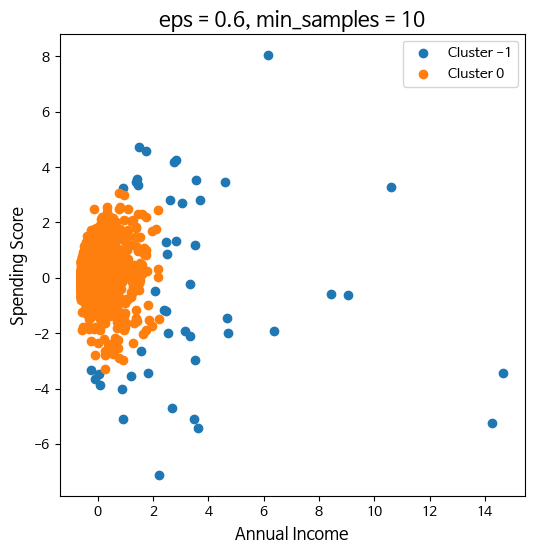

In [139]:
plt.figure(figsize = (6, 6))

# 이상치 번호는 -1, 클러스터 최대 숫자까지 iteration
for i in range(-1, dbscan_df['Cluster'].max() + 1):
    plt.scatter(dbscan_df.loc[dbscan_df['Cluster'] == i, 0], dbscan_df.loc[dbscan_df['Cluster'] == i, 1], label = 'Cluster ' + str(i))

plt.legend()
plt.title('eps = 0.6, min_samples = 10', size = 15)
plt.xlabel('Annual Income', size = 12)
plt.ylabel('Spending Score', size = 12)
plt.show()

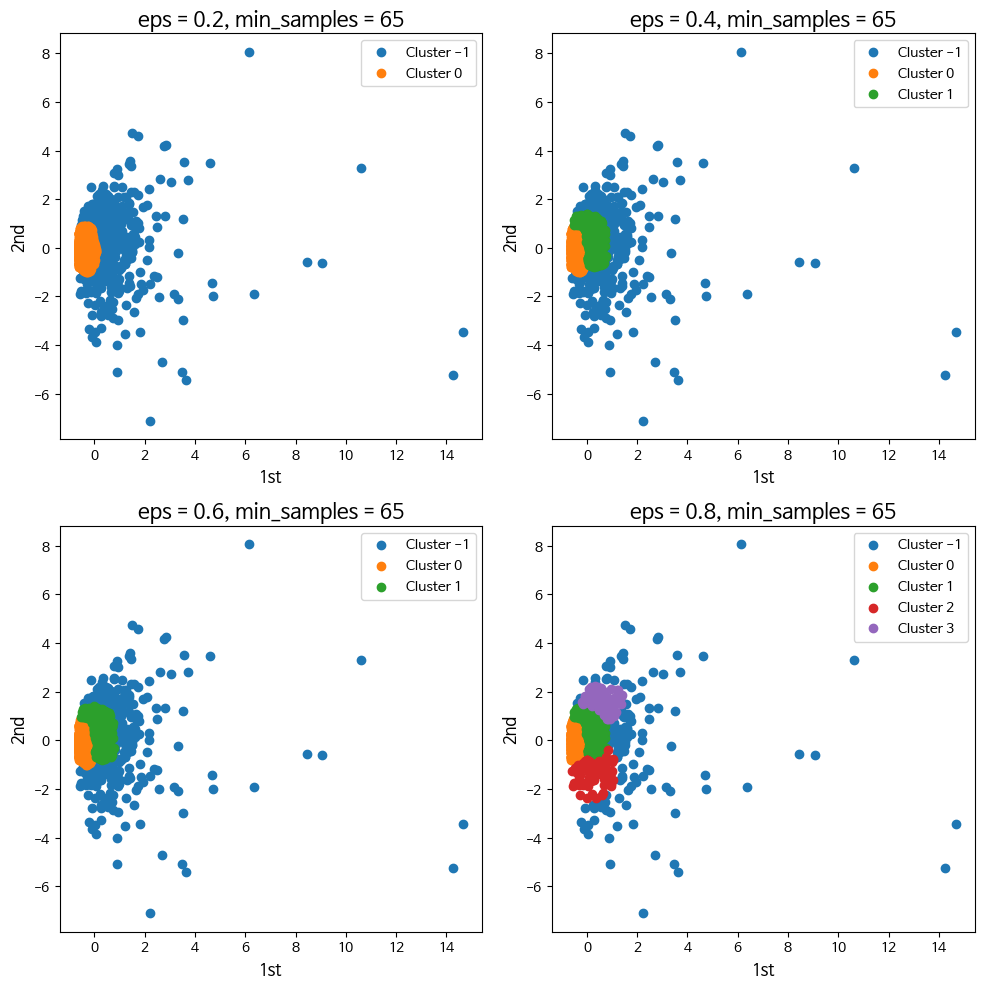

In [140]:
def draw_dbscan(scaled_df):
  # 다중 플롯 동시 시각화

  f, ax = plt.subplots(2, 2, figsize=(10, 10))

  for i in range(4):
    # epsilon을 증가시키면서 반복
    eps = 0.2 * (i + 1)
    min_samples = 65

    # 군집화 및 시각화 과정 자동화
    model = DBSCAN(eps=eps, min_samples=min_samples)

    model.fit(scaled_df)
    scaled_df['Cluster'] = model.fit_predict(scaled_df)
    scaled_df.columns = ['1st', '2nd', 'Cluster']

    for j in range(-1, scaled_df['Cluster'].max() + 1):
        ax[i // 2, i % 2].scatter(scaled_df.loc[scaled_df['Cluster'] == j, '1st'], scaled_df.loc[scaled_df['Cluster'] == j, '2nd'],
                        label = 'Cluster ' + str(j))

    ax[i // 2, i % 2].legend()
    ax[i // 2, i % 2].set_title('eps = %.1f, min_samples = %d'%(eps, min_samples), size = 15)
    ax[i // 2, i % 2].set_xlabel(scaled_df.columns[0], size = 12)
    ax[i // 2, i % 2].set_ylabel(scaled_df.columns[1], size = 12)
  plt.tight_layout()
  plt.show()

  return scaled_df

tmp_df = draw_dbscan(ss_pca_df)

---

In [141]:
dbscan_df = pd.concat([customer_buyinginfo_df, tmp_df['Cluster']], axis=1)
dbscan_df

고객ID  가입날짜  최초거래날짜  최근거래날짜  구매횟수  구매제품수      구매원가       할인가  \
0     USER_0000   988     108     108     1      3     35.69     24.98   
1     USER_0001   659     283      60    31    342  15902.78  15021.67   
2     USER_0002  1205     193      74     8    209   1645.73   1492.42   
3     USER_0003   764      18      18    11     21   1508.36   1339.57   
4     USER_0004   988     108     108    13     56   1594.23   1369.93   
...         ...   ...     ...     ...   ...    ...       ...       ...   
1463  USER_1463   183     271     271     3     46    595.58    582.38   
1464  USER_1464  1352     193      88    19    141   2640.23   2384.13   
1465  USER_1465   764     271     195     2     10    119.58    115.40   
1466  USER_1466  1499      70      70     1      2    327.80    327.80   
1467  USER_1467  1093     156      83    53    155   6946.00   6639.16   

         배송료     총결제금액  평균결제금액  평균할인차액  평균할인비율  구매제품평균금액  Cluster  
0      75.00     99.98   99.98  -10.71    0.11      8.33        0  
1     286.46  15308.13  493.81  -28.42    0.06     43.92       -1  
2      81.07   1573.49  196.69  -19.16    0.10      7.14        0  
3      82.39   1421.96  129.27  -15.34    0.12     63.79        1  
4     154.49   1524.42  117.26  -17.25    0.15     24.46        0  
...      ...       ...     ...     ...     ...       ...      ...  
1463   94.35    676.73  225.58   -4.40    0.02     12.66        0  
1464  222.05   2606.18  137.17  -13.48    0.10     16.91        0  
1465   12.50    127.90   63.95   -2.09    0.03     11.54        0  
1466    6.00    333.80  333.80    0.00    0.00    163.90        0  
1467  337.87   6977.03  131.64   -5.79    0.04     42.83        1  

[1468 rows x 15 columns]

---
# DF 정리
- 8 Features + pca + dbscan(0.8, 60) + 6개로 그룹화(이상치그룹 포함): dbscan_df
- 이상치 제거 + 5개 Features PCA + Kmeans + Normalize -> df

In [142]:
pca_iqr_df.value_counts('Cluster', sort=False)

Cluster
0    193
1    247
2    348
3    125
4    169
5    286
6    100
dtype: int64

- dbscan에서 이상치그룹 4로 변경

In [143]:
dbscan_df['Cluster'].replace({-1:4}, inplace=True)

In [144]:
dbscan_df.value_counts('Cluster', sort=False)

Cluster
0    920
1    247
2     93
3     68
4    140
dtype: int64

- 더 세밀하게 분배된 것으로 보이는 pca_iqr_df로 사용

---
# EDA

In [173]:
df = pca_iqr_df.copy()
df

고객ID  가입날짜  최초거래날짜  최근거래날짜  구매횟수  구매제품수      구매원가       할인가  \
0     USER_0000   988     108     108     1      3     35.69     24.98   
1     USER_0001   659     283      60    31    342  15902.78  15021.67   
2     USER_0002  1205     193      74     8    209   1645.73   1492.42   
3     USER_0003   764      18      18    11     21   1508.36   1339.57   
4     USER_0004   988     108     108    13     56   1594.23   1369.93   
...         ...   ...     ...     ...   ...    ...       ...       ...   
1463  USER_1463   183     271     271     3     46    595.58    582.38   
1464  USER_1464  1352     193      88    19    141   2640.23   2384.13   
1465  USER_1465   764     271     195     2     10    119.58    115.40   
1466  USER_1466  1499      70      70     1      2    327.80    327.80   
1467  USER_1467  1093     156      83    53    155   6946.00   6639.16   

         배송료     총결제금액  평균결제금액  평균할인차액  평균할인비율  구매제품평균금액  Cluster  
0      75.00     99.98   99.98  -10.71    0.11      8.33        5  
1     286.46  15308.13  493.81  -28.42    0.06     43.92        6  
2      81.07   1573.49  196.69  -19.16    0.10      7.14        2  
3      82.39   1421.96  129.27  -15.34    0.12     63.79        5  
4     154.49   1524.42  117.26  -17.25    0.15     24.46        5  
...      ...       ...     ...     ...     ...       ...      ...  
1463   94.35    676.73  225.58   -4.40    0.02     12.66        1  
1464  222.05   2606.18  137.17  -13.48    0.10     16.91        0  
1465   12.50    127.90   63.95   -2.09    0.03     11.54        2  
1466    6.00    333.80  333.80    0.00    0.00    163.90        5  
1467  337.87   6977.03  131.64   -5.79    0.04     42.83        3  

[1468 rows x 15 columns]

In [174]:
df.groupby('Cluster').mean()

가입날짜      최초거래날짜      최근거래날짜       구매횟수       구매제품수  \
Cluster                                                              
0        792.834197  162.191710   66.590674  23.901554  181.590674   
1        862.765182  305.145749  287.566802   5.542510   38.587045   
2        801.011494  204.037356  155.752874   6.448276   41.847701   
3        843.184000  271.672000  131.568000  38.336000  411.960000   
4        828.408284  296.242604  214.591716  20.775148  180.047337   
5        819.486014   71.020979   52.136364   7.755245   43.090909   
6        828.680000  257.530000   75.830000  78.840000  846.450000   

                 구매원가           할인가         배송료         총결제금액      평균결제금액  \
Cluster                                                                     
0         4573.490052   4245.687306  201.573627   4447.260933  196.026528   
1          919.064372    867.323279   59.834494    927.157773  167.067490   
2          954.182155    888.838075   54.463937    943.302011  142.864799   
3         7407.558880   6910.600240  357.946480   7268.546720  201.419840   
4         3726.117811   3497.362189  189.814260   3687.176450  198.064379   
5         1434.264476   1318.584580   62.440455   1381.025035  186.548042   
6        17777.407500  16657.799600  716.714300  17374.513900  245.640200   

            평균할인차액    평균할인비율   구매제품평균금액  
Cluster                                  
0       -14.063420  0.073886  36.463834  
1        -8.539028  0.051296  40.776032  
2        -9.785316  0.069310  33.070603  
3       -14.128480  0.069280  24.683680  
4       -11.667574  0.063905  29.500237  
5       -14.936503  0.091259  54.913077  
6       -15.501400  0.065900  26.077200

In [175]:
df.groupby('Cluster').mean().describe()

가입날짜      최초거래날짜      최근거래날짜       구매횟수       구매제품수  \
count    7.000000    7.000000    7.000000   7.000000    7.000000   
mean   825.195596  223.977200  140.576633  25.942676  249.081952   
std     23.882522   84.480625   86.490410  26.171142  295.066418   
min    792.834197   71.020979   52.136364   5.542510   38.587045   
25%    810.248754  183.114533   71.210337   7.101760   42.469305   
50%    828.408284  257.530000  131.568000  20.775148  180.047337   
75%    835.932000  283.957302  185.172295  31.118777  296.775337   
max    862.765182  305.145749  287.566802  78.840000  846.450000   

               구매원가           할인가         배송료         총결제금액      평균결제금액  \
count      7.000000      7.000000    7.000000      7.000000    7.000000   
mean    5256.012178   4912.313610  234.683936   5146.997546  191.090183   
std     6001.965242   5625.259390  239.226496   5863.652003   31.829812   
min      919.064372    867.323279   54.463937    927.157773  142.864799   
25%     1194.223315   1103.711328   61.137474   1162.163523  176.807766   
50%     3726.117811   3497.362189  189.814260   3687.176450  196.026528   
75%     5990.524466   5578.143773  279.760053   5857.903826  199.742109   
max    17777.407500  16657.799600  716.714300  17374.513900  245.640200   

          평균할인차액    평균할인비율   구매제품평균금액  
count   7.000000  7.000000   7.000000  
mean  -12.660246  0.069262  35.069238  
std     2.696083  0.012028  10.424452  
min   -15.501400  0.051296  24.683680  
25%   -14.532492  0.064903  27.788718  
50%   -14.063420  0.069280  33.070603  
75%   -10.726445  0.071598  38.619933  
max    -8.539028  0.091259  54.913077

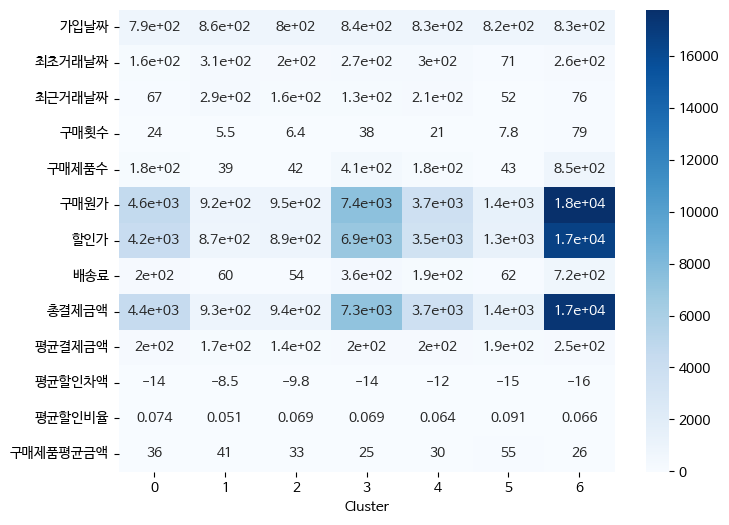

In [176]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.groupby('Cluster').mean().T, annot=True, cmap='Blues')
plt.show()

## 고객구분
- 구매제품평균금액(할인가/구매제품수)은 고객 등급을 정하는 데에는 크게 반영하지 않음.
  - 저렴한 제품을 대량 구매하는 경우, 총결제금액은 높지만 구매제품평균금액은 낮아지기 때문.
- 표시된 화살표는 각 클러스터별 특성의 평균값을 기준으로 함
  - 따라서 예를 들어, 총결제금액의 평균값이 낮아도 총결제금액의 sum은 높을 수 있음

<center>
<img src='https://drive.google.com/uc?id=1ONVEGYrikpSsWF0734CLPNBgywvizufR'><br>
</center>

- 고객 그룹 7단계
  - VVIP: 최근거래, 구매횟수▲, 총결제금액▲, 매출비중▲
  - VIP : 최근거래, 구매횟수▲, 총결제금액▲, 매출비중=  
  - Regular: 최근거래, 구매횟수▼, 총결제금액▼, 매출비중=
  - Newcomer: 최근거래, 구매횟수▼, 총결제금액▼, 매출비중▼ **=> 결제금액을 높여야 하는 그룹**
  - Need Attention: 드문거래, 구매횟수▼, 총결제금액▼, 매출비중▲, 고객수▲ **=> 재방문 유도와 결제금액을 높여야 하는 그룹**
  - About to Sleep: 희소한 거래, 구매횟수▼, 총결제금액▼, 매출비중= **=> 재방문 유도 필요**
  - Sleep: 희소한 거래, 구매횟수▼, 총결제금액▼, 매출비중▼, 고객수▲ **=> 재방문 유도 필요**

In [177]:
df = pd.concat([customer_buyinginfo_df, df[['Cluster']]], axis=1)
df

고객ID  가입날짜  최초거래날짜  최근거래날짜  구매횟수  구매제품수      구매원가       할인가  \
0     USER_0000   988     108     108     1      3     35.69     24.98   
1     USER_0001   659     283      60    31    342  15902.78  15021.67   
2     USER_0002  1205     193      74     8    209   1645.73   1492.42   
3     USER_0003   764      18      18    11     21   1508.36   1339.57   
4     USER_0004   988     108     108    13     56   1594.23   1369.93   
...         ...   ...     ...     ...   ...    ...       ...       ...   
1463  USER_1463   183     271     271     3     46    595.58    582.38   
1464  USER_1464  1352     193      88    19    141   2640.23   2384.13   
1465  USER_1465   764     271     195     2     10    119.58    115.40   
1466  USER_1466  1499      70      70     1      2    327.80    327.80   
1467  USER_1467  1093     156      83    53    155   6946.00   6639.16   

         배송료     총결제금액  평균결제금액  평균할인차액  평균할인비율  구매제품평균금액  Cluster  
0      75.00     99.98   99.98  -10.71    0.11      8.33        5  
1     286.46  15308.13  493.81  -28.42    0.06     43.92        6  
2      81.07   1573.49  196.69  -19.16    0.10      7.14        2  
3      82.39   1421.96  129.27  -15.34    0.12     63.79        5  
4     154.49   1524.42  117.26  -17.25    0.15     24.46        5  
...      ...       ...     ...     ...     ...       ...      ...  
1463   94.35    676.73  225.58   -4.40    0.02     12.66        1  
1464  222.05   2606.18  137.17  -13.48    0.10     16.91        0  
1465   12.50    127.90   63.95   -2.09    0.03     11.54        2  
1466    6.00    333.80  333.80    0.00    0.00    163.90        5  
1467  337.87   6977.03  131.64   -5.79    0.04     42.83        3  

[1468 rows x 15 columns]

In [178]:
groupname = {0: 'Regular', 1: 'Sleep', 2: 'Need Attention', 3: 'VIP', 4: 'About to Sleep', 5: 'Newcomer', 6: 'VVIP'}
df['Cluster'].replace(groupname, inplace=True)
df

고객ID  가입날짜  최초거래날짜  최근거래날짜  구매횟수  구매제품수      구매원가       할인가  \
0     USER_0000   988     108     108     1      3     35.69     24.98   
1     USER_0001   659     283      60    31    342  15902.78  15021.67   
2     USER_0002  1205     193      74     8    209   1645.73   1492.42   
3     USER_0003   764      18      18    11     21   1508.36   1339.57   
4     USER_0004   988     108     108    13     56   1594.23   1369.93   
...         ...   ...     ...     ...   ...    ...       ...       ...   
1463  USER_1463   183     271     271     3     46    595.58    582.38   
1464  USER_1464  1352     193      88    19    141   2640.23   2384.13   
1465  USER_1465   764     271     195     2     10    119.58    115.40   
1466  USER_1466  1499      70      70     1      2    327.80    327.80   
1467  USER_1467  1093     156      83    53    155   6946.00   6639.16   

         배송료     총결제금액  평균결제금액  평균할인차액  평균할인비율  구매제품평균금액         Cluster  
0      75.00     99.98   99.98  -10.71    0.11      8.33        Newcomer  
1     286.46  15308.13  493.81  -28.42    0.06     43.92            VVIP  
2      81.07   1573.49  196.69  -19.16    0.10      7.14  Need Attention  
3      82.39   1421.96  129.27  -15.34    0.12     63.79        Newcomer  
4     154.49   1524.42  117.26  -17.25    0.15     24.46        Newcomer  
...      ...       ...     ...     ...     ...       ...             ...  
1463   94.35    676.73  225.58   -4.40    0.02     12.66           Sleep  
1464  222.05   2606.18  137.17  -13.48    0.10     16.91         Regular  
1465   12.50    127.90   63.95   -2.09    0.03     11.54  Need Attention  
1466    6.00    333.80  333.80    0.00    0.00    163.90        Newcomer  
1467  337.87   6977.03  131.64   -5.79    0.04     42.83             VIP  

[1468 rows x 15 columns]

In [179]:
# 저장
# df.to_csv('customer_cluster_1_kimjihyun.csv', sep=',', encoding='utf8')

In [184]:
df.groupby('Cluster')['총결제금액'].sum()

Cluster
About to Sleep     623132.82
Need Attention     328269.10
Newcomer           394973.16
Regular            858321.36
Sleep              229007.97
VIP                908568.34
VVIP              1737451.39
Name: 총결제금액, dtype: float64

In [203]:
df['Cluster'].value_counts()

Need Attention    348
Newcomer          286
Sleep             247
Regular           193
About to Sleep    169
VIP               125
VVIP              100
Name: Cluster, dtype: int64

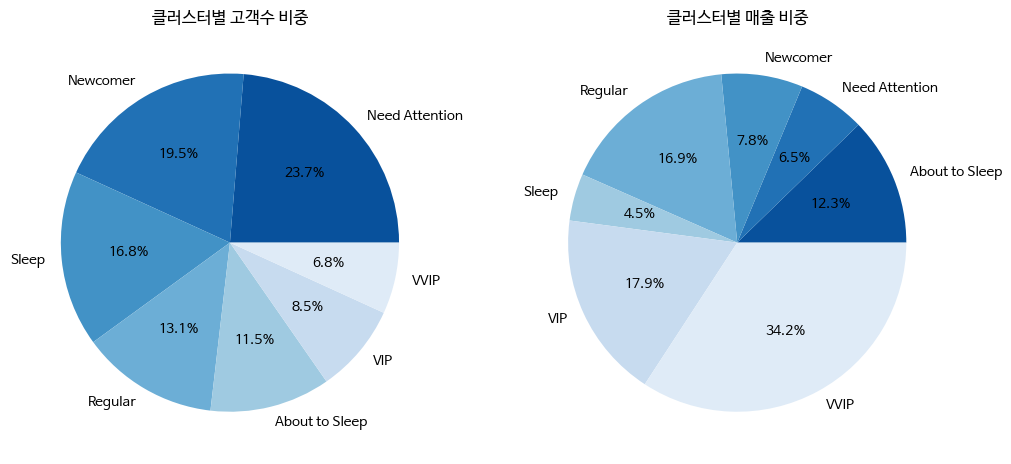

In [202]:
plt.figure(figsize=(12, 8))

colors = sns.color_palette('Blues_r', 7) ## 라벨의 개수 만큼 색상 리스트 생성

plt.subplot(121)
plt.pie(df['Cluster'].value_counts(), colors=colors, autopct='%1.1f%%', labels=df['Cluster'].value_counts().index)
plt.title('클러스터별 고객수 비중')

plt.subplot(122)
plt.pie(df.groupby('Cluster')['총결제금액'].sum(), colors=colors, autopct='%1.1f%%', labels=df.groupby('Cluster')['총결제금액'].sum().index)
plt.title('클러스터별 매출 비중')

plt.show()

- 우량고객과 신규고객(Regular, VIP, VVIP)에 비해 관심과 유도가 많이 필요한 Need Attention, About to Sleep, Sleep 고객들이 50%의 비중을 차지하는 것으로 나타났다.
- 매출 향상을 위해 고객 수 비중과 매출 비중에서 큰 비중을 차지하는 3가지 하위 그룹에 대한 적극적인 마케팅 전략을 펼쳐야 한다.

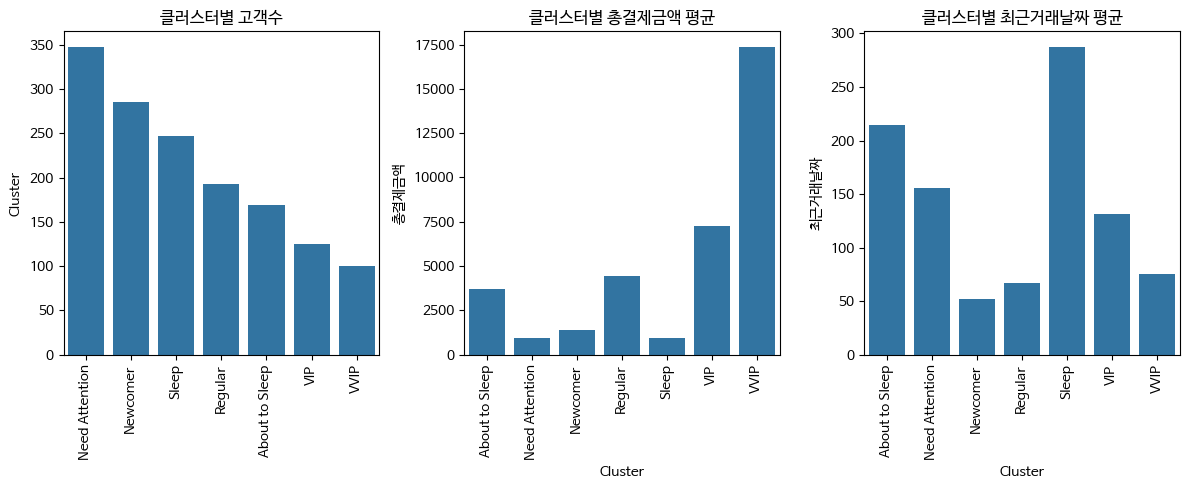

In [193]:
plt.figure(figsize=(12, 5))

plt.subplot(131)
sns.barplot(df['Cluster'].value_counts())
plt.xticks(rotation=90)
plt.title('클러스터별 고객수')

plt.subplot(132)
sns.barplot(df.groupby('Cluster')['총결제금액'].mean())
plt.xticks(rotation=90)
plt.title('클러스터별 총결제금액 평균')

plt.subplot(133)
sns.barplot(df.groupby('Cluster')['최근거래날짜'].mean())
plt.xticks(rotation=90)
plt.title('클러스터별 최근거래날짜 평균')   # 낮을 수록 좋음

plt.tight_layout()
plt.show()

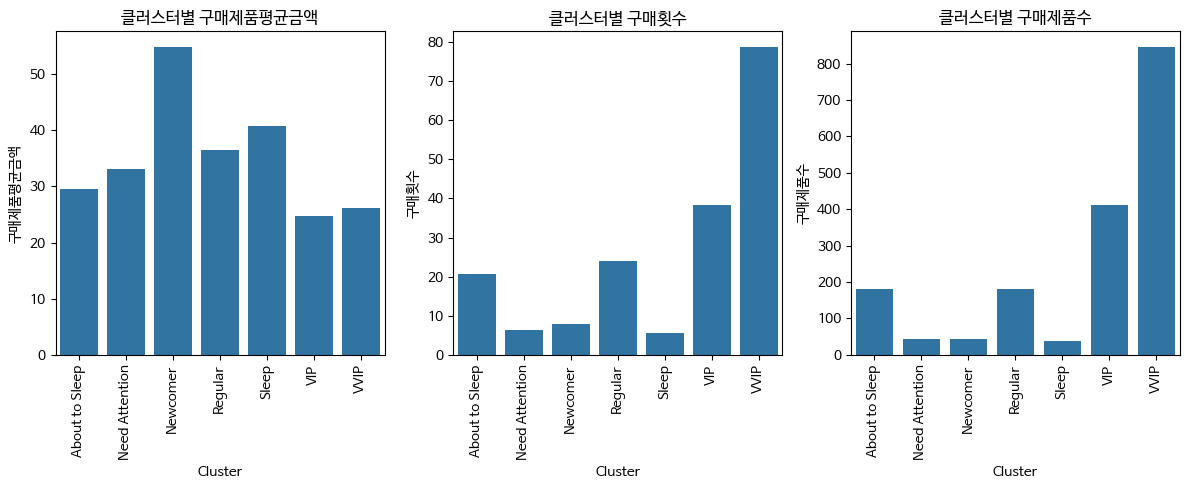

In [190]:
plt.figure(figsize=(12, 5))

plt.subplot(131)
sns.barplot(df.groupby('Cluster')['구매제품평균금액'].mean())
plt.xticks(rotation=90)
plt.title('클러스터별 구매제품평균금액')

plt.subplot(132)
sns.barplot(df.groupby('Cluster')['구매횟수'].mean())
plt.xticks(rotation=90)
plt.title('클러스터별 구매횟수')

plt.subplot(133)
sns.barplot(df.groupby('Cluster')['구매제품수'].mean())
plt.xticks(rotation=90)
plt.title('클러스터별 구매제품수')

plt.tight_layout()
plt.show()